In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

# Helper Functions

In [2]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Calculate distance
    distance = R * c
    return distance

In [3]:
df = pd.read_excel("swainson's hawk.xlsx")
df['date'] = pd.to_datetime(df['date'])
df.head()

species birdID       date  longitude  latitude
0  Swainson's hawk   SW16 1996-10-08    -98.184    28.840
1  Swainson's hawk   SW16 1996-10-09    -98.877    29.120
2  Swainson's hawk   SW16 1996-10-10    -99.299    25.879
3  Swainson's hawk   SW16 1996-10-11    -98.326    22.770
4  Swainson's hawk   SW16 1996-10-12    -96.021    17.831

In [4]:
def migratory_stretch_estimator(df):
    # Calculate distance and time difference for each bird ID
    result_data = []

    # Iterate over each unique bird ID
    for bird_id, group_df in df.groupby('birdID'):
        first_entry = True
        # Calculate distance and time difference for each row in the group
        for index, row in group_df.iterrows():
            if first_entry:
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']
                first_entry = False
            else:
                distance = haversine(row['longitude'], row['latitude'], prev_longitude, prev_latitude)

                time_difference = (row['date'] - prev_date).days
                
                result_data.append({
                    'birdID': bird_id,
                    'distance': distance,
                    'time': time_difference
                })
                
                # Update previous values for the next iteration
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']

    # Create a new DataFrame from the result data
    result_df = pd.DataFrame(result_data)
    return result_df

In [7]:
SWH_dist = migratory_stretch_estimator(df)
SWH_dist

birdID     distance  time
0     SW16    77.196132     1
1     SW16    73.753169     1
2     SW16   120.422288     1
3     SW16   265.087782     1
4     SW16  1272.416610     9
..     ...          ...   ...
158   SW25   483.053535     6
159   SW25   419.507241     7
160   SW25  1550.947945     6
161   SW25  1504.535960     7
162   SW25  1705.738579    13

[163 rows x 3 columns]

In [8]:
SWH_dist[SWH_dist['time'] < 3][SWH_dist['distance'] < 500]['distance'].max()

C:\Users\Yashraj Deshmukh\AppData\Local\Temp\ipykernel_4180\4016690045.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SWH_dist[SWH_dist['time'] < 3][SWH_dist['distance'] < 500]['distance'].max()


477.0961216935548

In [9]:
SWH_dist[SWH_dist['distance'] < 478]['distance'].median() , SWH_dist[SWH_dist['distance'] < 478]['distance'].mean()

(134.635304338803, 162.19031381977132)

In [8]:
SWH_migratory_stretch = 478
SWH_median_migration = 135
SWH_mean_migration = 163

In [5]:
def create_migration_network(data, max_migration, keep=False):
    groups = []
    for bird_id, group_df in data.groupby('birdID'):
        groups.append(group_df)

    # Create an empty graph
    migration_network = nx.Graph()

    # Iterate over each group of bird movements
    for bird_group in groups:
        # Extract latitude and longitude coordinates for the bird's movements
        points = list(zip(bird_group['latitude'], bird_group['longitude']))
        
        if keep:
            # Add edges based on the original connections
            for i in range(len(points) - 1):
                migration_network.add_edge(points[i], points[i + 1])
        else:
            # Add nodes to the network
            for point in points:
                migration_network.add_node(point)

    # Iterate again to add additional edges based on maximum migration distance
    all_nodes = migration_network.nodes()
    for node1 in all_nodes:
        for node2 in all_nodes:
            if node1 != node2:
                # Calculate distance between two nodes using Haversine formula
                distance = haversine(node1[0], node1[1], node2[0], node2[1])
                # If distance is less than max_migration, add an edge between the two nodes
                if distance < max_migration:
                    migration_network.add_edge(node1, node2)

    return migration_network

In [10]:
SWH_network = create_migration_network(df, SWH_migratory_stretch)
print(SWH_network)

Graph with 167 nodes and 1050 edges


In [11]:
# Add edges to the SWH_network
SWH_network.add_edge((16.873, -93.871), (34.712, -113.315))
SWH_network.add_edge((28.277, -102.317), (37.669, -120.664))
SWH_network.add_edge((25.437, -103.972), (35.15, -118.945))
SWH_network.add_edge((25.062, -107.464), (33.85, -116.99))
print(SWH_network)

Graph with 167 nodes and 1054 edges


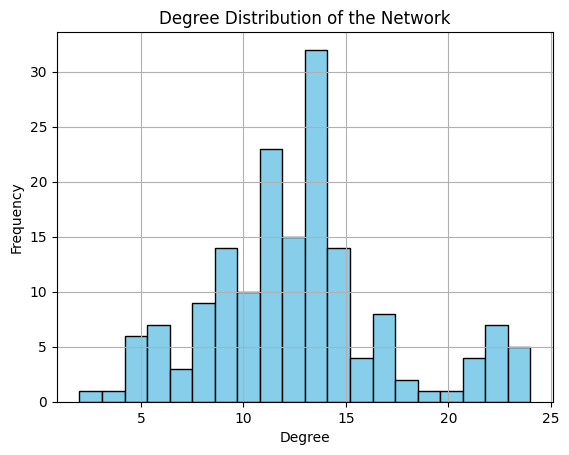

In [80]:
degrees = dict(SWH_network.degree())
# Plot degree distribution
plt.hist(list(degrees.values()), bins=20, color='skyblue', edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
def plot_migration_network_on_world_map(migration_network):
    plt.figure(figsize=(10, 8))
    
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color='blue', alpha=0.5)
    nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    plt.title('Migration Network on World Map')
    plt.show()

In [73]:
len(list(nx.connected_components(SWH_network)))

1

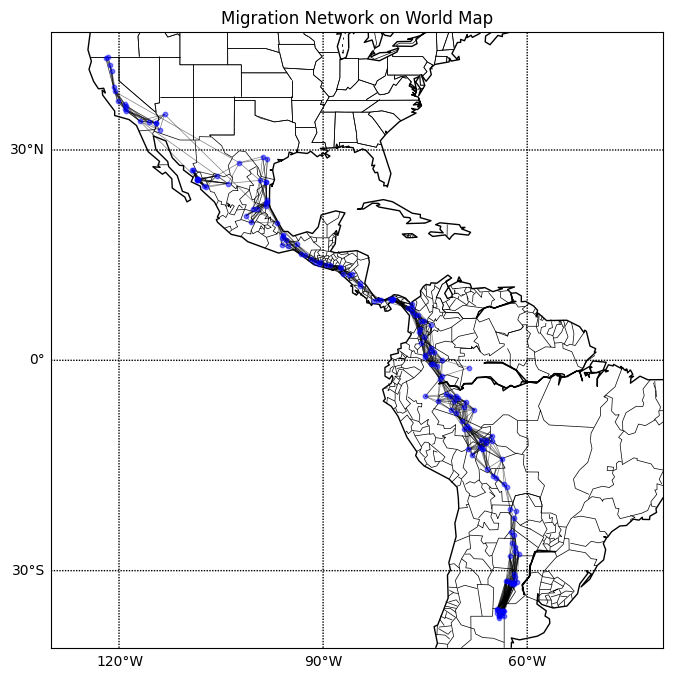

In [81]:
plot_migration_network_on_world_map(SWH_network)

In [7]:
def estimate_k_bisection(d_prime, tolerance=0.01, max_iterations=1000):
    # Define the function f(d) = e^-kd
    def f(d, k):
        return math.exp(-k * d)
    
    # Define the target value
    target_value = 0.5
    
    # Define the initial bounds for k
    lower_bound = 0
    upper_bound = 1
    # lies in 0 to 1 since k has dimension (km)^-1
    
    # Perform bisection search
    iterations = 0
    while iterations < max_iterations:
        # Calculate the midpoint and the corresponding function value
        midpoint = (lower_bound + upper_bound) / 2
        result = f(d_prime, midpoint)
        
        # Check if the result is within tolerance of the target value
        if abs(result - target_value) < tolerance:
            return midpoint
        
        # Update the bounds based on the sign of the result
        if result < target_value:
            upper_bound = midpoint
        else:
            lower_bound = midpoint
        
        iterations += 1
    
    # If max_iterations is reached without convergence, return None
    return None

In [14]:
k_SWH = estimate_k_bisection(SWH_median_migration)
print("Estimated value of Dispersal Constant, k:", k_SWH)

n_SWH = df["birdID"].nunique()
print("No. of Swainson's Hawk, n :", n_SWH)

Estimated value of Dispersal Constant, k: 0.005126953125
No. of Swainson's Hawk, n : 4


In [21]:
#  p ( d )  is the probability of dispersing at least distance d, and k is the dispersal coefficient
def p(d, k):
    return math.exp(-k * d)

print(p(SWH_median_migration, k_SWH))
print(p(SWH_median_migration, 1/SWH_mean_migration))

print(p(SWH_migratory_stretch, k_SWH))
print(p(SWH_migratory_stretch, 1/SWH_mean_migration))

# max dist
print(p(2186, k_SWH))
print(p(2186, 1/SWH_mean_migration))

# min dist
print(p(0.68, k_SWH))
print(p(0.68, 1/SWH_mean_migration))

0.5005045087004147
0.436825770062579
0.08623461690089532
0.05326289535477274
1.3571758146295913e-05
1.498504503605287e-06
0.996519742060629
0.9958369106413459


In [8]:
def p(d, k):
    return math.exp(-k * d)

def weight_of_edge(n, k, d):
    return n * p(d, k)

for u, v in SWH_network.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    SWH_network[u][v]['weight'] = weight

[2.733566414829803, 0.6746163924544545, 0.49270817921050375, 0.6450883120568042, 0.6540633706143847, 0.6227266965486709, 0.6705217510436223, 0.5444951526861428, 0.5517802777242576, 0.6333350190646168]


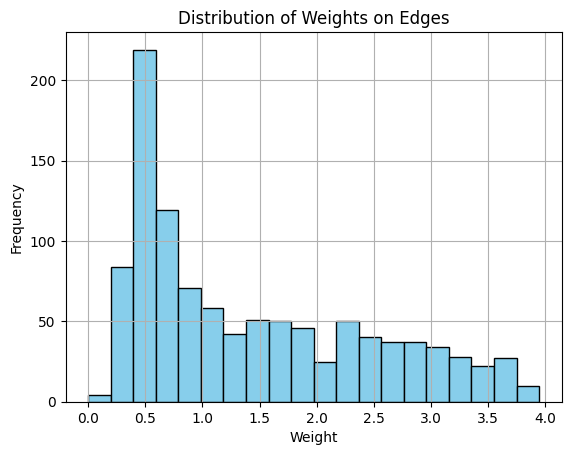

In [62]:
# Extract the weights from the edges
weights = [SWH_network[u][v]["weight"] for u,v in SWH_network.edges()]

print(weights[:10])

# Plot the distribution of weights
plt.hist(weights, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Weights on Edges')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

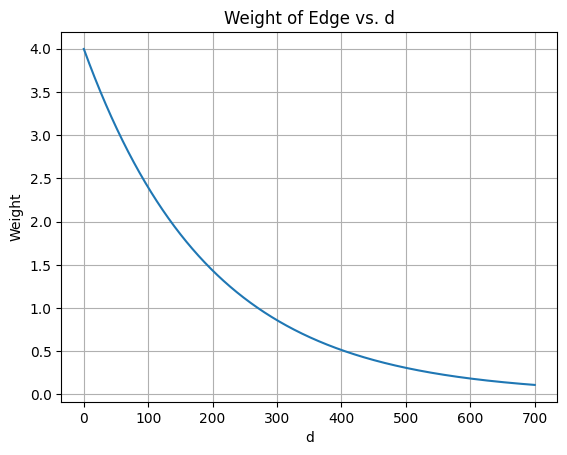

In [25]:
d_values = np.linspace(0.1, 700, 7000)  # Vary d from 0.1 to 700
weights_ = [weight_of_edge(n_SWH, k_SWH, d) for d in d_values]

plt.plot(d_values, weights_)
plt.xlabel('d')
plt.ylabel('Weight')
plt.title('Weight of Edge vs. d')
plt.grid(True)
plt.show()

In [9]:
def plot_weighted_migration_network_on_world_map(migration_network):
    """
    Plot the migration network on a world map using latitude and longitude values for node positions.
    
    Parameters:
        - migration_network: NetworkX graph representing the migration network.
    """
    # Create a new figure
    plt.figure(figsize=(10, 20))

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58)

    # Draw coastlines, countries, and states with reduced opacity
    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    m.drawstates(linewidth=0.2)

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}
    
    # Create color maps for edges and nodes based on weight and degree ranges
    edge_colors = ['#ff9896', '#ffbb78', 'brown', 'indigo', '#9edae5', '#aec7e8']  # Define colors for edge weight ranges
    degree_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Define colors for node degree ranges
    
    # Define edge weight ranges and corresponding labels
    edge_weight_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, float('inf'))]
    edge_labels = [f'{start}-{end}' if end != float('inf') else f'>{start}' for start, end in edge_weight_ranges]
    
    # Define node degree ranges and corresponding labels
    node_degree_ranges = [(0,5),(6, 10), (11, 15), (16, 20), (21, 25)]
    degree_labels = [f'{start}-{end}' for start, end in node_degree_ranges]
    
    # Draw nodes
    for node, degree in migration_network.degree():
        # Assign node size based on degree
        node_size = 2 * degree
        
        # Assign color based on node degree range
        for i, (start, end) in enumerate(node_degree_ranges):
            if start <= degree <= end:
                node_color = degree_colors[i]
                break
        
        nx.draw_networkx_nodes(migration_network, pos, nodelist=[node], node_size=node_size, node_color=node_color, alpha=0.5)
    
    # Draw edges
    for edge in migration_network.edges():
        # Get edge weight
        weight = migration_network[edge[0]][edge[1]].get('weight', 1000)
        
        # Assign color based on edge weight range
        for i, (start, end) in enumerate(edge_weight_ranges):
            if start <= weight < end:
                edge_color = edge_colors[i]
                break
        
        nx.draw_networkx_edges(migration_network, pos, edgelist=[edge], width=weight + 1, edge_color=edge_color, alpha=0.5) #(1 if (weight<2 and weight>1) else 0.01))
    
    # Create legend patches for edge colors and node degrees
    edge_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(edge_colors, edge_labels)]
    degree_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(degree_colors, degree_labels)]
    
    # Draw legend for both edge colors and node degrees
    plt.legend(handles=edge_patches + degree_patches, title='Edge Weights and\nNode Degrees', loc='upper right', fontsize='small')

    plt.title('Migration Network on World Map')
    plt.show()

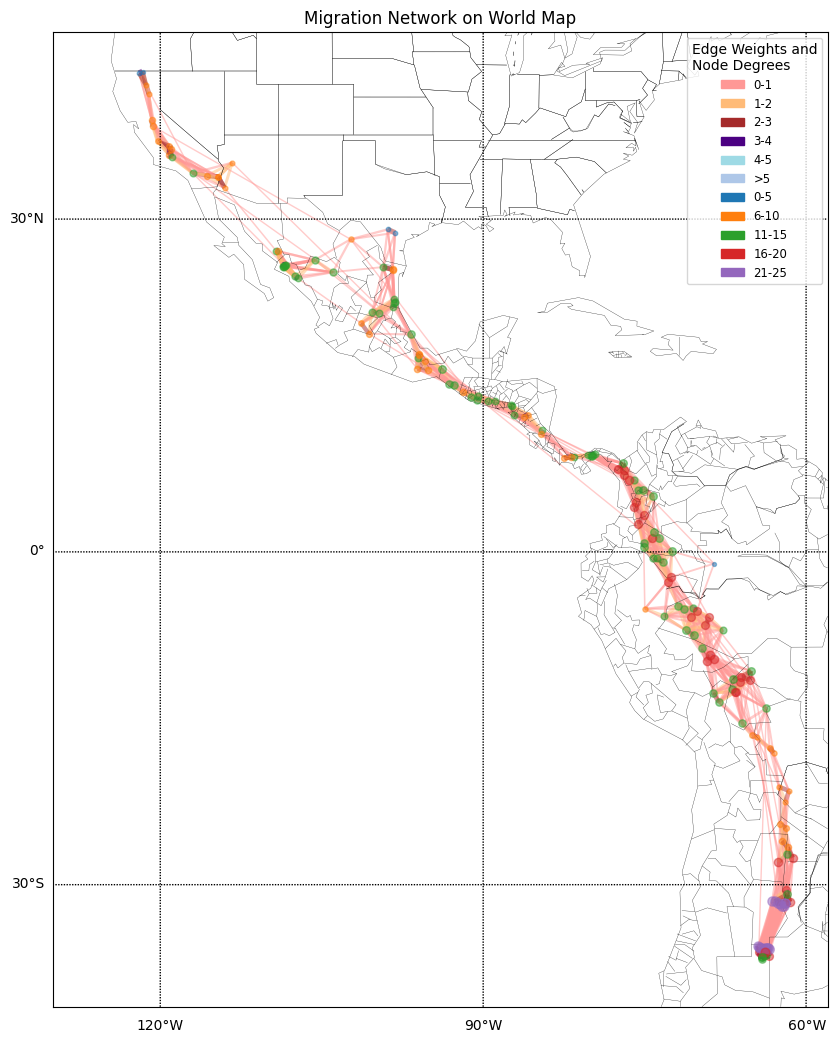

In [50]:
plot_weighted_migration_network_on_world_map(SWH_network)

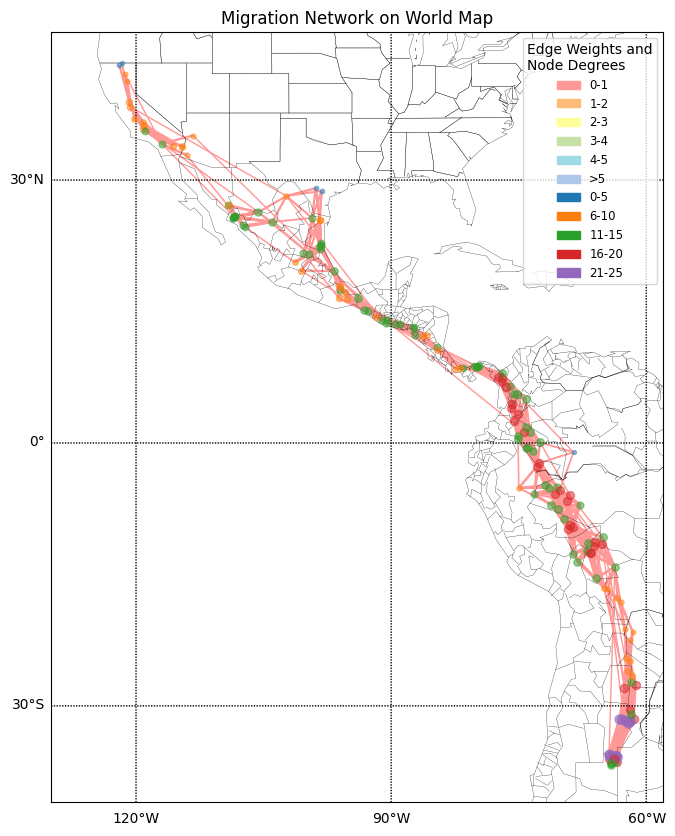

In [33]:
plot_weighted_migration_network_on_world_map(SWH_network)

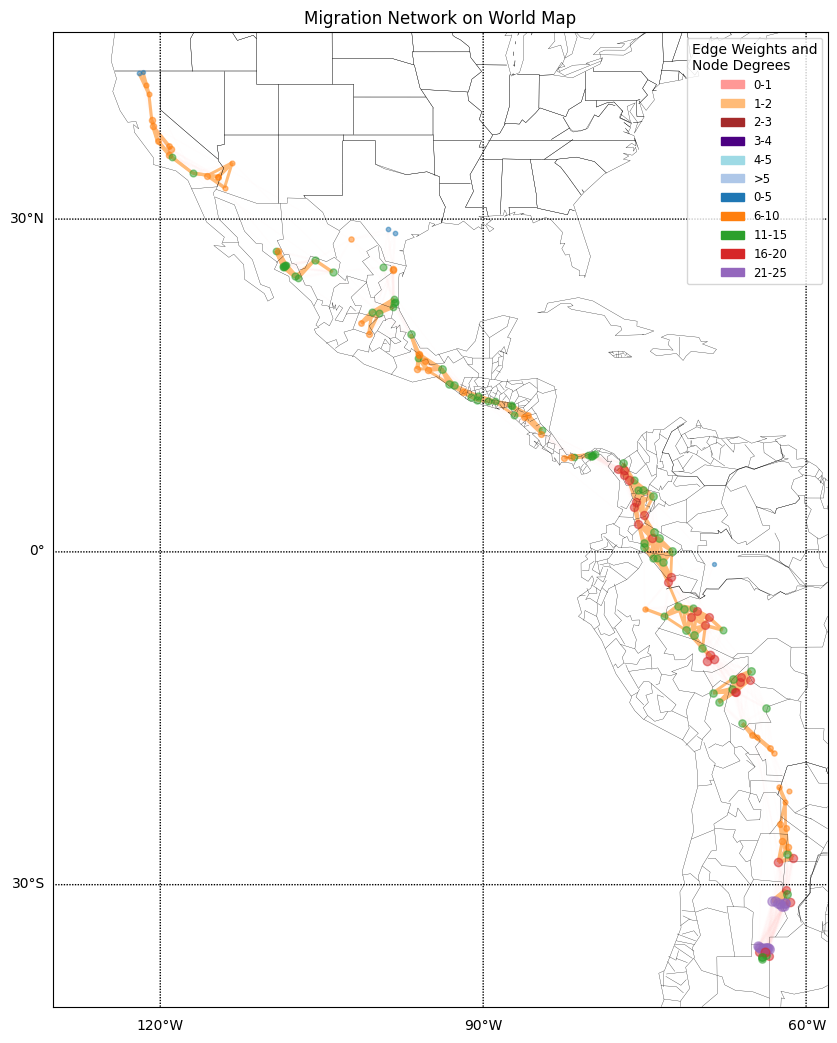

In [48]:
plot_weighted_migration_network_on_world_map(SWH_network)

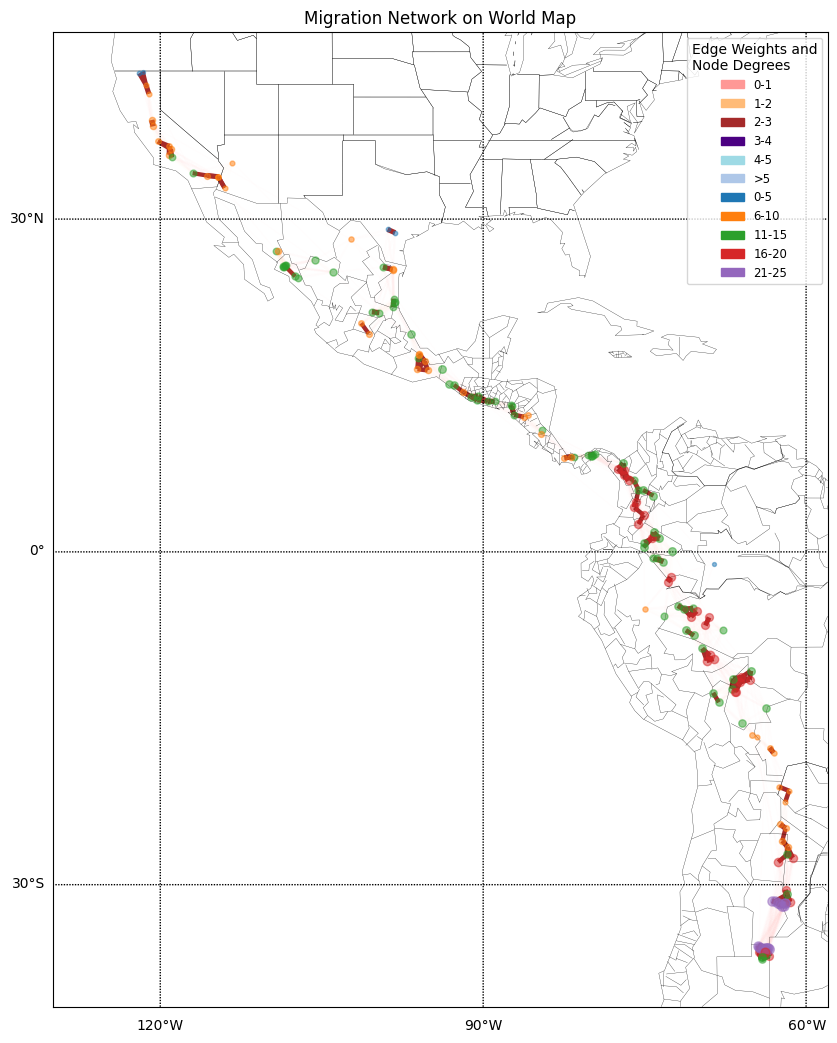

In [42]:
plot_weighted_migration_network_on_world_map(SWH_network)

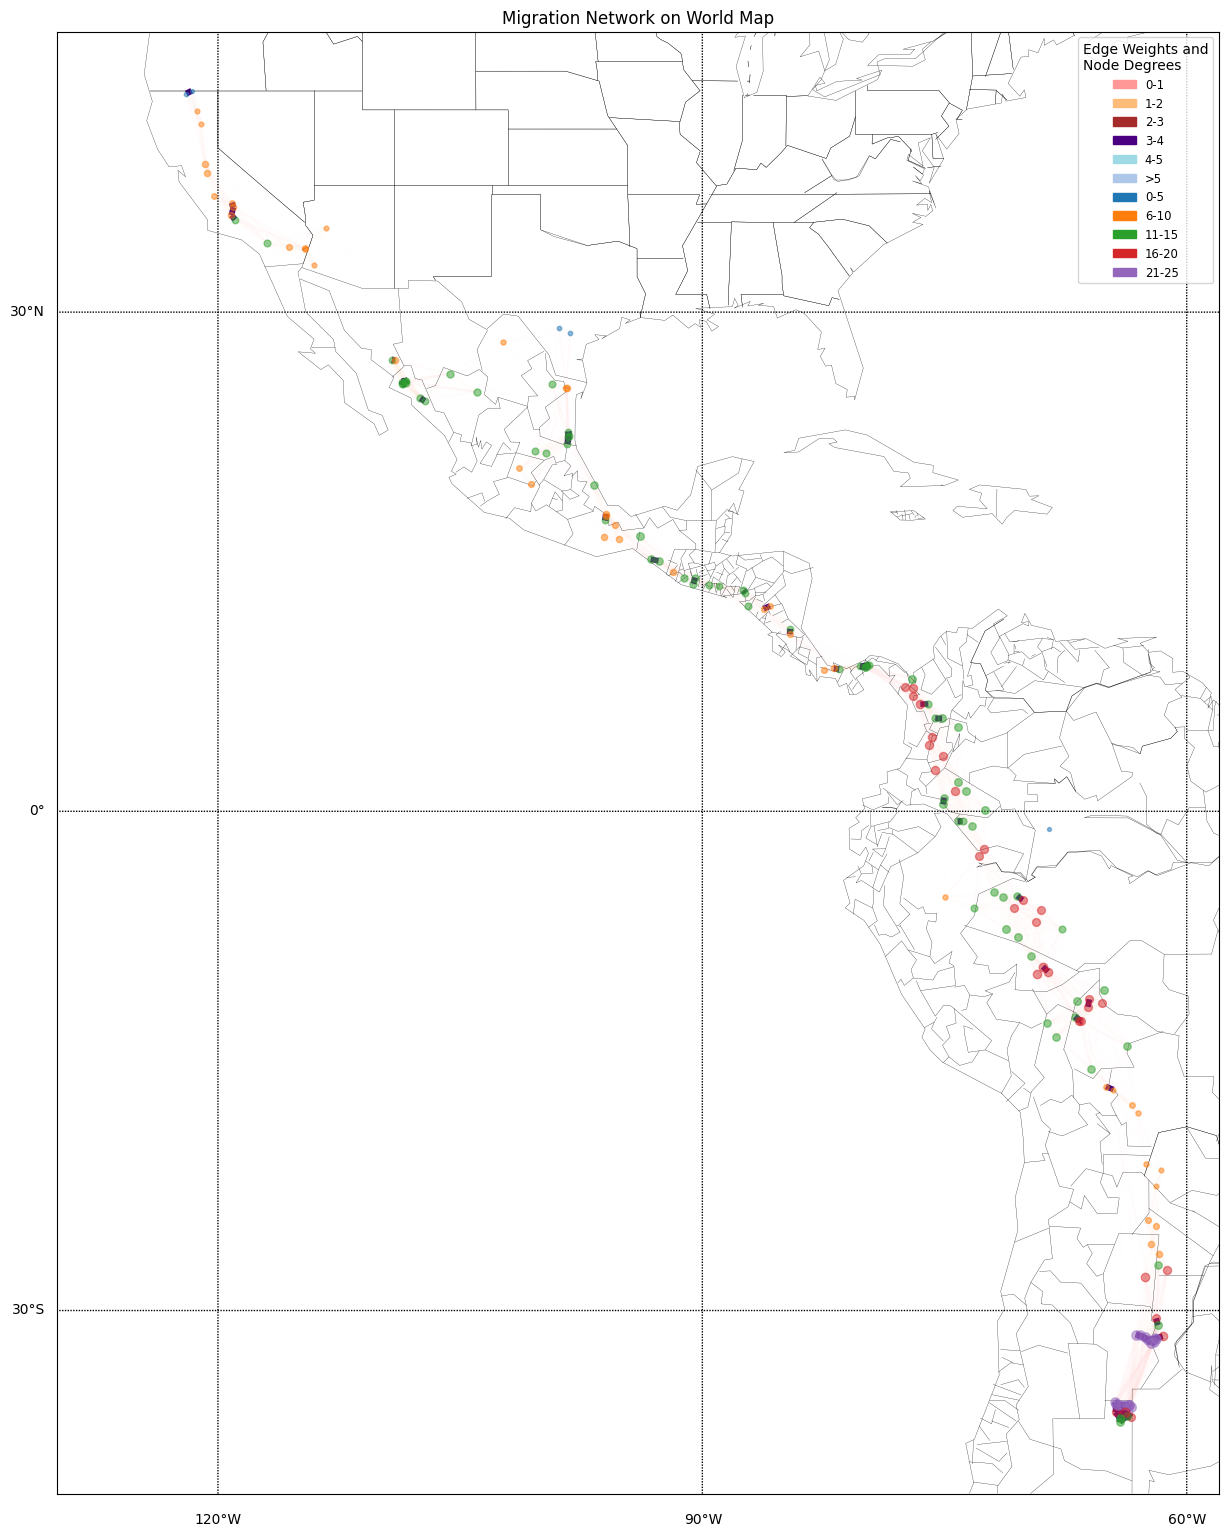

In [46]:
plot_weighted_migration_network_on_world_map(SWH_network)

In [10]:
def plot_weighted_migration_network_on_world_map(migration_network):
    # Create a new figure
    plt.figure(figsize=(10, 20))

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58)

    # Draw coastlines, countries, and states with reduced opacity
    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    m.drawstates(linewidth=0.2)

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}
    
    # Create color maps for edges and nodes based on weight and degree ranges
    # Define colors for edge weight ranges
    edge_colors = ['violet', 'grey', 'brown', 'indigo', 'pink']  
    # Define colors for node degree ranges
    degree_colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']   
    
    # Define edge weight ranges and corresponding labels
    edge_weight_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
    edge_labels = [f'{start}-{end}' for start, end in edge_weight_ranges]
    
    # Define node degree ranges and corresponding labels
    node_degree_ranges = [(5, 10), (11, 15), (16, 20), (21, 25), (26, 30), (31, 35)]
    degree_labels = [f'{start}-{end}' for start, end in node_degree_ranges]
    
    # Draw nodes
    for node, degree in migration_network.degree():
        # Assign node size based on degree
        node_size = degree
        
        # Assign color based on node degree range
        for i, (start, end) in enumerate(node_degree_ranges):
            if start <= degree <= end:
                node_color = degree_colors[i]
                break
        
        nx.draw_networkx_nodes(migration_network, pos, nodelist=[node], node_size=node_size, node_color=node_color, alpha=0.5)
    
    # Draw edges
    for edge in migration_network.edges():
        # Get edge weight
        weight = migration_network[edge[0]][edge[1]].get('weight', 4)  # Default weight to 1 if not set
        
        if weight==4: print(f"weight not found for {edge}")
        # if weight<1:
        #     a = 0.1
        # elif weight<2:
        #     a = 0.2
        # elif weight<3:
        #     a = 0.4
        # else:
        #     a = 0.8
        a = 0.5

        # Assign color based on edge weight range
        for i, (start, end) in enumerate(edge_weight_ranges):
            if start <= weight < end:
                edge_color = edge_colors[i]
                break
        
        nx.draw_networkx_edges(migration_network, pos, edgelist=[edge], width=weight + 1, edge_color=edge_color, alpha=a)
    
    # Create legend patches for edge colors and node degrees
    edge_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(edge_colors, edge_labels)]
    degree_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(degree_colors, degree_labels)]
    
    # Draw legend for both edge colors and node degrees
    plt.legend(handles=edge_patches + degree_patches, title='Edge Weights and\nNode Degrees', loc='upper right', fontsize='small')

    plt.title('Migration Network on World Map')
    plt.show()

# Initial Network

In [11]:
SWH_migratory_stretch = 676
SWH_median_migration = 165
SWH_mean_migration = 205

In [12]:
SWH_network = create_migration_network(df, SWH_migratory_stretch, keep=True)
print(SWH_network)

Graph with 167 nodes and 1566 edges


1


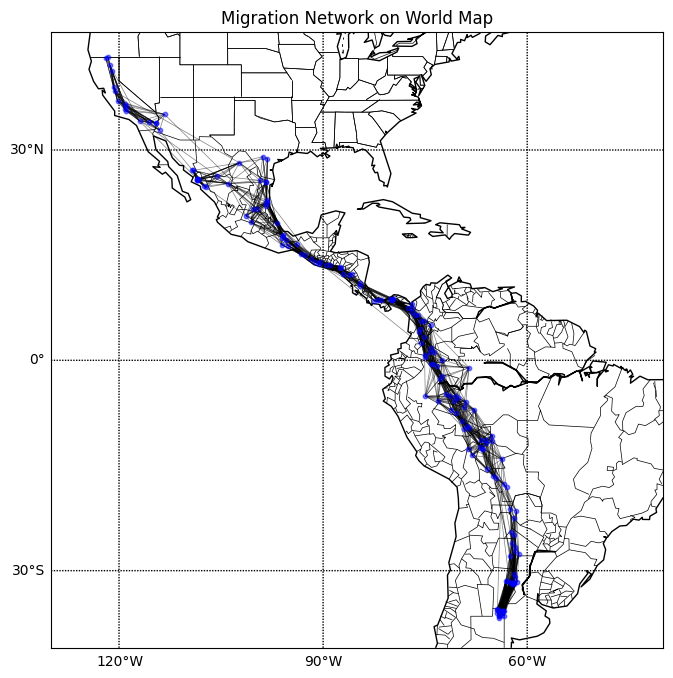

In [85]:
print(len(list(nx.connected_components(SWH_network))))
plot_migration_network_on_world_map(SWH_network)

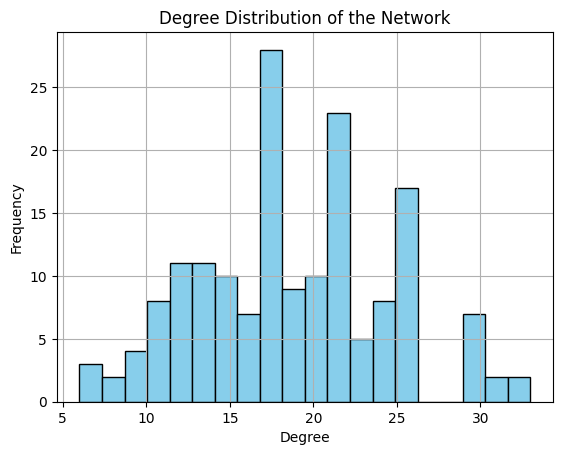

In [90]:
degrees = dict(SWH_network.degree())
# Plot degree distribution
plt.hist(list(degrees.values()), bins=20, color='skyblue', edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
k_SWH = estimate_k_bisection(SWH_median_migration)
print("Estimated value of Dispersal Constant, k:", k_SWH)

n_SWH = df["birdID"].nunique()
print("No. of Swainson's Hawk, n :", n_SWH)

for u, v in SWH_network.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    SWH_network[u][v]['weight'] = weight

Estimated value of Dispersal Constant, k: 0.004150390625
No. of Swainson's Hawk, n : 4


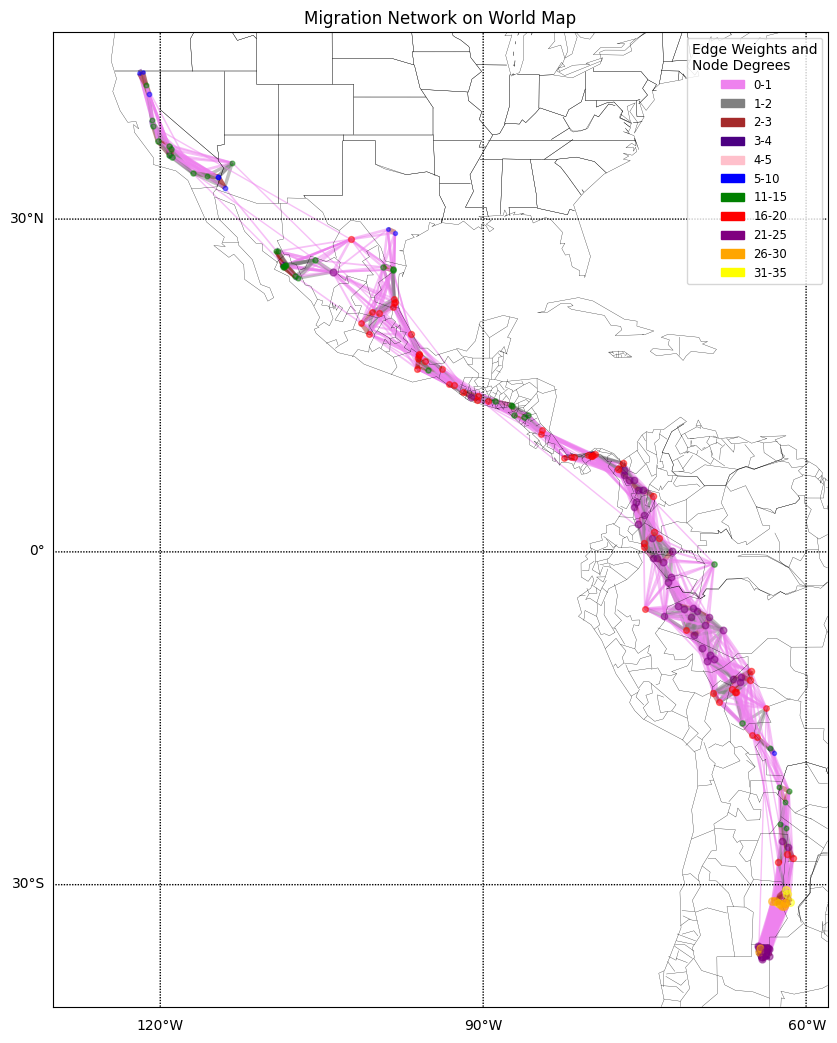

In [94]:
plot_weighted_migration_network_on_world_map(SWH_network)

# Node Locator

In [14]:
def plot_migration_network_vul(migration_network, vulnerable : list, nI=False):
    fig = plt.figure(figsize=(10, 8))
    
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    # Create a list of colors for the nodes
    colors = []
    vul_nodes = []

    for node in migration_network.nodes():
        # Check if the node is in the intersection of the rectangles
        if vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] >= node[1] >= vulnerable[3]:
            colors.append('yellow')
            vul_nodes.append(node)
        else:
            colors.append('blue')

    print(f"Vulnerable nodes = {len(vul_nodes)}: {vul_nodes}")

    # Draw the nodes with the specified colors
    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color=colors, alpha=0.5)
    # nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    if True:
        # Define the latitude and longitude range for the horizontal rectangle
        lower_left_lat = vulnerable[0]
        lower_left_lon = -180
        upper_right_lat = vulnerable[1]
        upper_right_lon = 180

        # Convert the latitude and longitude to map coordinates
        lower_left_x, lower_left_y = m(lower_left_lon, lower_left_lat)
        upper_right_x, upper_right_y = m(upper_right_lon, upper_right_lat)

        # Create a horizontal rectangle
        rect_horizontal = mpatches.Rectangle((lower_left_x, lower_left_y), upper_right_x - lower_left_x, upper_right_y - lower_left_y,
                                linewidth=1, edgecolor='r', facecolor='r', alpha=0.4)

        # Add the horizontal rectangle to the plot
        plt.gca().add_patch(rect_horizontal)

        # Define the latitude and longitude range for the vertical rectangle
        lower_left_lat = -90
        lower_left_lon = vulnerable[2]
        upper_right_lat = 90
        upper_right_lon = vulnerable[3]

        # Convert the latitude and longitude to map coordinates
        lower_left_x, lower_left_y = m(lower_left_lon, lower_left_lat)
        upper_right_x, upper_right_y = m(upper_right_lon, upper_right_lat)

        # Create a vertical rectangle
        rect_vertical = mpatches.Rectangle((lower_left_x, lower_left_y), upper_right_x - lower_left_x, upper_right_y - lower_left_y,
                                linewidth=1, edgecolor='r', facecolor='r', alpha=0.4)

        # Add the vertical rectangle to the plot
        plt.gca().add_patch(rect_vertical)

    plt.title('Migration Network on World Map')
    if nI : plt.show()
    else: return fig

In [123]:
node = (13.873, -87.871)
vulnerable = [13,14,-87,-88]
vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] <= node[1] <= vulnerable[3]

False

Vulnerable nodes = 2: [(13.432, -87.335), (13.601, -87.456)]


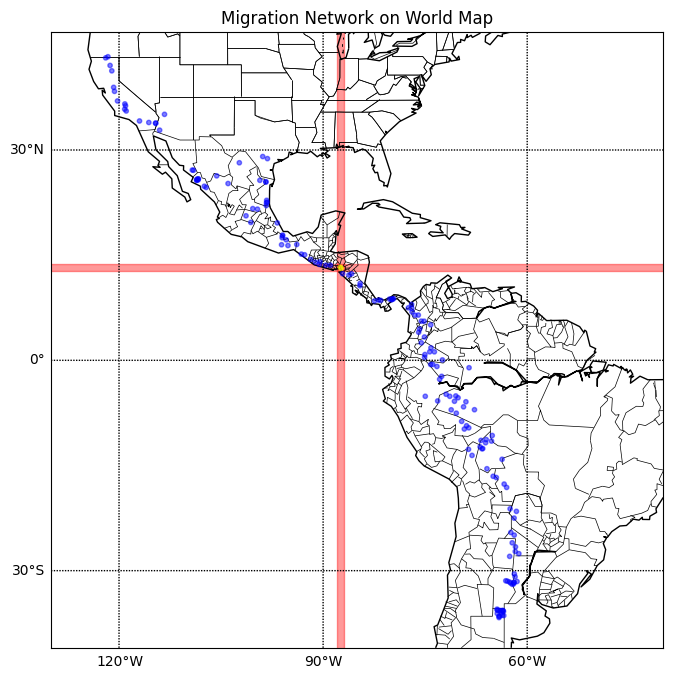

In [132]:
plot_migration_network_vul(SWH_network, [13,14,-87,-88], True)

Vulnerable nodes = 0: []


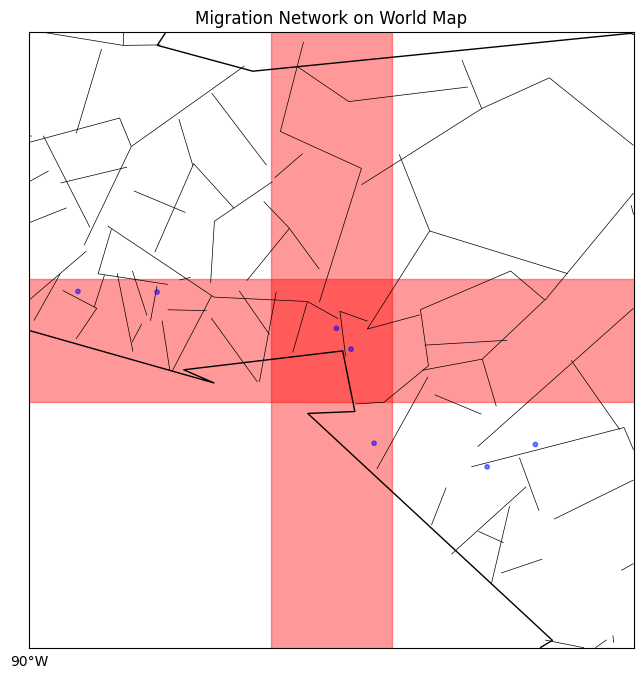

In [114]:
plot_migration_network_vul(SWH_network, [13,14,-87,-88], True)

Vulnerable nodes = 7: [(13.9, -89.592), (13.432, -87.335), (13.601, -87.456), (12.667, -87.144), (14.004, -90.551), (13.895, -88.938), (14.384, -90.45)]


FloatSlider(value=9.600000000000001, description='vulnerable[0]', max=45.0, min=-40.0)

FloatSlider(value=16.400000000000006, description='vulnerable[1]', max=45.0, min=-40.0)

FloatSlider(value=-86.4, description='vulnerable[2]', max=-40.0, min=-130.0)

FloatSlider(value=-90.80000000000001, description='vulnerable[3]', max=-40.0, min=-130.0)

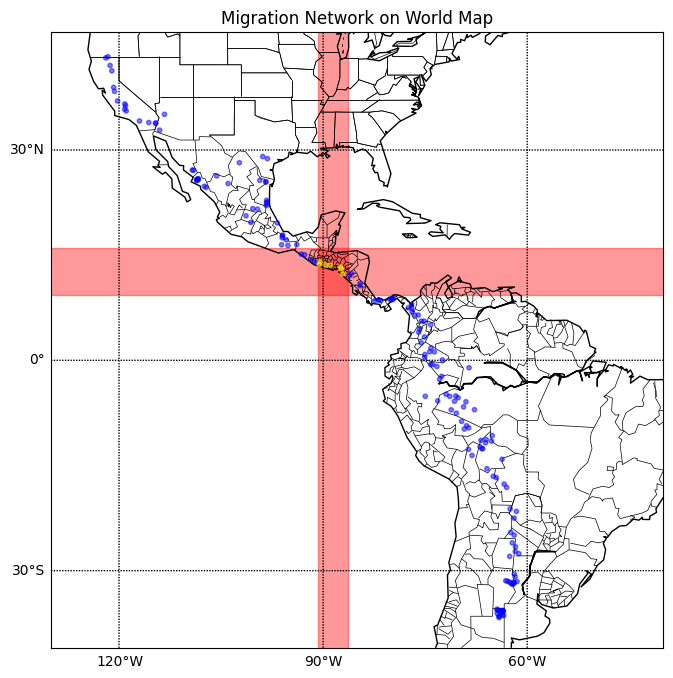

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create sliders for the vulnerable values
slider1 = widgets.FloatSlider(min=-40, max=45, step=0.1, description='vulnerable[0]')
slider2 = widgets.FloatSlider(min=-40, max=45, step=0.1, description='vulnerable[1]')
slider3 = widgets.FloatSlider(min=-130, max=-40, step=0.1, description='vulnerable[2]')
slider4 = widgets.FloatSlider(min=-130, max=-40, step=0.1, description='vulnerable[3]')

# Display the sliders
display(slider1, slider2, slider3, slider4)

# Define a function to update the plot when the slider values change
def update_plot(change):
    clear_output(wait=True)
    vulnerable = [slider1.value, slider2.value, slider3.value, slider4.value]
    fig = plot_migration_network_vul(SWH_network, vulnerable)  # Get the figure from the function
    display(slider1, slider2, slider3, slider4)
    return fig

# Add the update function as a callback for when the slider values change
slider1.observe(update_plot, 'value')
slider2.observe(update_plot, 'value')
slider3.observe(update_plot, 'value')
slider4.observe(update_plot, 'value')

# Call the update_plot function initially to display the initial plot
update_plot(None)

# Call the plot function initially
# vulnerable = [slider1.value, slider2.value, slider3.value, slider4.value]
# plot_migration_network_vul(SWH_network, vulnerable)

In [16]:
def vulnerable_nodes(migration_network, vulnerable):
    vul_nodes = []

    for node in migration_network.nodes():
        if vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] >= node[1] >= vulnerable[3]:
            vul_nodes.append(node)

    return vul_nodes

vulnerable_nodes(SWH_network, [13,14,-87,-88])

[(13.432, -87.335), (13.601, -87.456)]

In [17]:
def delete_vulnerable_nodes(network, vulnerable):
    # Create a copy of the network
    network_copy = network.copy()
    
    # Find vulnerable nodes
    vuln_nodes = vulnerable_nodes(network, vulnerable)
    
    # Delete vulnerable nodes from the network
    network_copy.remove_nodes_from(vuln_nodes)
    
    # Check the number of connected components
    num_components = nx.number_connected_components(network_copy)
    
    return num_components

delete_vulnerable_nodes(SWH_network, [15,30,-90,-120])

2

Vulnerable nodes = 4: [(-21.495, -62.512), (-22.796, -61.923), (-21.854, -61.586), (-24.79, -62.407)]


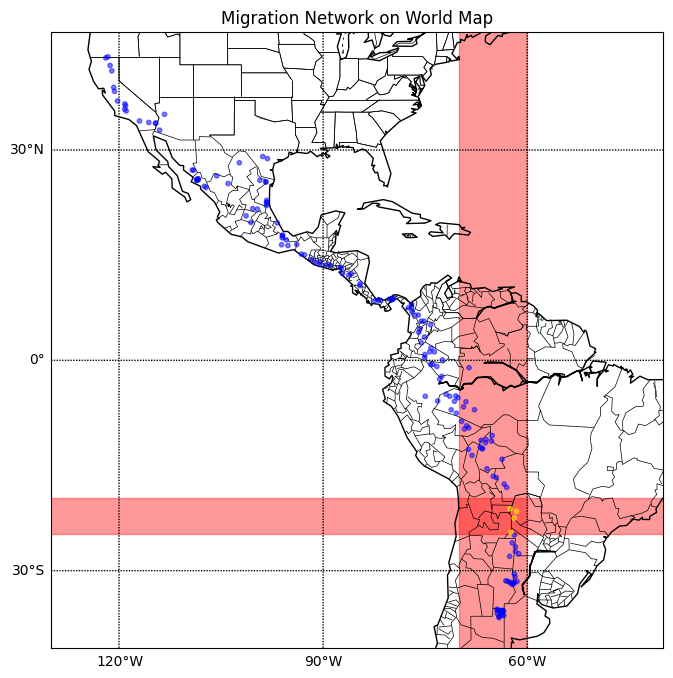

In [140]:
plot_migration_network_vul(SWH_network, [-25,-20,-60,-70], True)

In [139]:
delete_vulnerable_nodes(SWH_network, [-25,-20,-60,-70])

1

# Bird Trail Creation

In [18]:
group1 = df[df["birdID"] == "SW16"]
group2 = df[df["birdID"] == "SW17"]
group3 = df[df["birdID"] == "SW18"]
group4 = df[df["birdID"] == "SW25"]

In [20]:
# Find the node with the highest latitude
highest_lat_node = group1[group1['latitude'] == group1['latitude'].max()]

# Find the node with the lowest latitude
lowest_lat_node = group1[group1['latitude'] == group1['latitude'].min()]

# Print the results
print("Node with highest latitude:")
print(highest_lat_node)

print("\nNode with lowest latitude:")
print(lowest_lat_node)

(34.712, -113.315) in SWH_16.nodes() , (-36.172, -64.143) in SWH_16.nodes()

Node with highest latitude:
            species birdID       date  longitude  latitude
32  Swainson's hawk   SW16 1997-05-02   -113.315    34.712

Node with lowest latitude:
            species birdID       date  longitude  latitude
22  Swainson's hawk   SW16 1996-12-09    -64.143   -36.172


(True, True)

In [19]:
# Create an empty undirected graph for each group
SWH_16 = nx.Graph()
SWH_17 = nx.Graph()
SWH_18 = nx.Graph()
SWH_25 = nx.Graph()

# Function to add edges to a graph from a group
def add_edges_from_group(graph, group):
    # Sort the group by timestamp if necessary
    group = group.sort_values('date')
    
    # Get the points in the group
    points = list(group[['latitude', 'longitude']].itertuples(index=False, name=None))
    
    # Add an edge between each pair of consecutive points
    for i in range(len(points) - 1):
        graph.add_edge(points[i], points[i + 1])

# Add edges to the graphs from the groups
add_edges_from_group(SWH_16, group1)
add_edges_from_group(SWH_17, group2)
add_edges_from_group(SWH_18, group3)
add_edges_from_group(SWH_25, group4)

In [144]:
def plot_trail_on_world_map(migration_network, ax, label=False):
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color='blue', alpha=0.5, ax=ax)
    nx.draw_networkx_edges(migration_network, pos, width=0.5, edge_color='red',alpha=0.9, ax=ax)
    
    if label:
        nx.draw_networkx_labels(migration_network, pos, font_size=10, ax=ax)

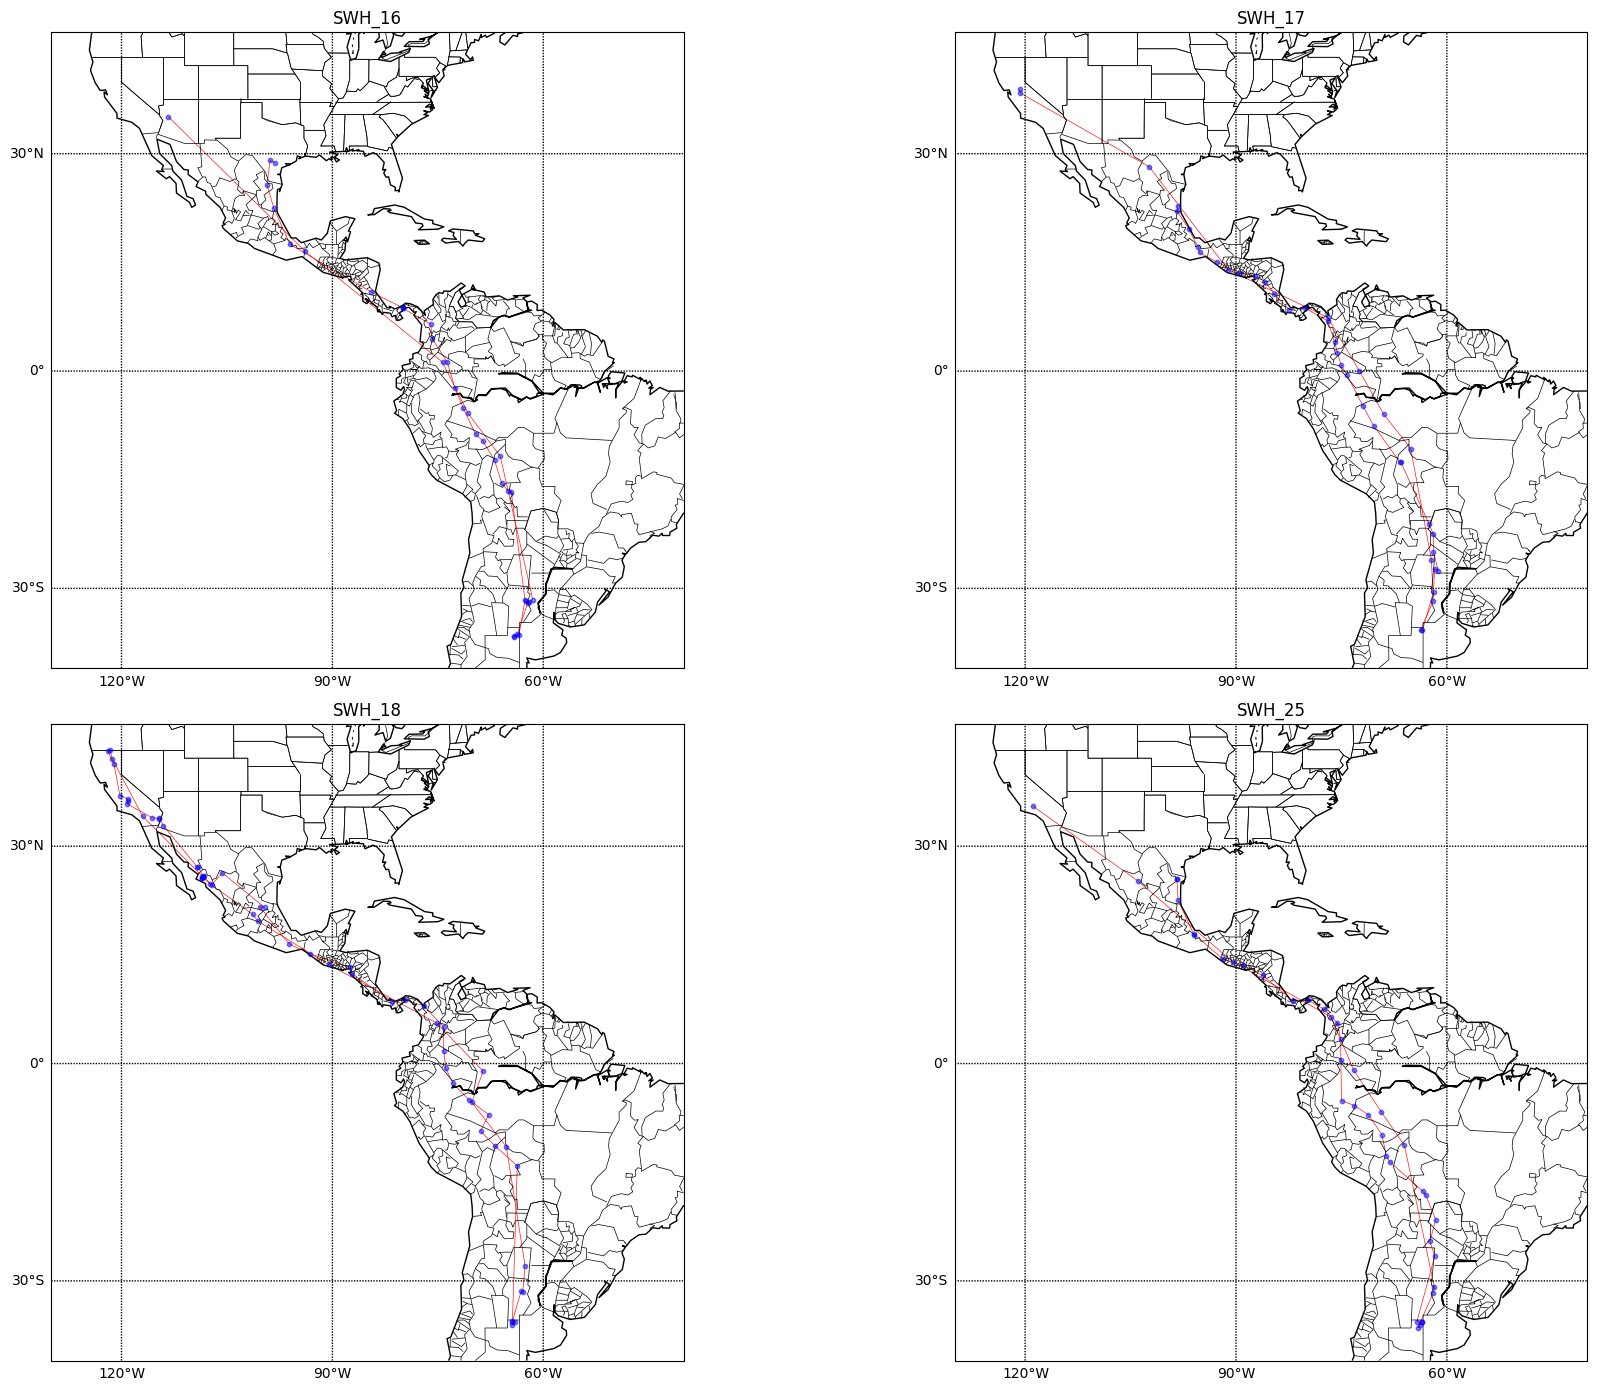

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

plot_trail_on_world_map(SWH_16, axs[0, 0])
axs[0, 0].set_title('SWH_16')

plot_trail_on_world_map(SWH_17, axs[0, 1])
axs[0, 1].set_title('SWH_17')

plot_trail_on_world_map(SWH_18, axs[1, 0])
axs[1, 0].set_title('SWH_18')

plot_trail_on_world_map(SWH_25, axs[1, 1])
axs[1, 1].set_title('SWH_25')

plt.tight_layout()
plt.show()

# Shortest Trail Traversal

### Brute

In [22]:
import sys

def minimumCostSimplePath(G, u, destination, visited, path):
    # Check if we find the destination then further cost will be 0
    if u == destination:
        # print(path)
        return path + [u], 0

    # Marking the current node as visited
    visited[u] = True
    path.append(u)

    ans = sys.maxsize
    min_path = None

    # Traverse through all the adjacent nodes
    for v in G[u]:
        if not visited[v]:
            # Cost of the further path
            curr_path, curr = minimumCostSimplePath(G, v, destination, visited, path)

            # Check if we have reached the destination
            if curr != sys.maxsize:
                # Taking the minimum cost path
                if 1/G[u][v]['weight'] + curr < ans:
                    ans = 1/G[u][v]['weight'] + curr
                    min_path = curr_path

    # Unmarking the current node to make it available for other simple paths
    visited[u] = False
    path.remove(u)

    # Returning the minimum cost
    return min_path, ans

In [71]:
import random
# Create a copy of SWH_16
G = SWH_16.copy()

# G.add_edge((16.873, -93.871),(-35.86, -63.687))
# G.add_edge((-12.056, -66.116),(-31.659, -62.419))

print(G)

# Get a list of all nodes
nodes = list(G.nodes())

# Iterate over all pairs of nodes
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        # Add an edge with probability 0.4
        if random.random() < 0.05:
            G.add_edge(nodes[i], nodes[j])

print(G)

for u, v in G.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    G[u][v]['weight'] = weight

# Add nodes and edges to G
visited = {node: False for node in G.nodes}
start_node = (34.712, -113.315)
end_node = (-36.172, -64.143)
path, cost = minimumCostSimplePath(G, start_node, end_node, visited, [])

Graph with 33 nodes and 32 edges
Graph with 33 nodes and 50 edges


In [72]:
cost , path

(449.50885061996416,
 [(34.712, -113.315),
  (29.12, -98.877),
  (25.879, -99.299),
  (22.77, -98.326),
  (17.831, -96.021),
  (11.255, -84.559),
  (8.916, -79.887),
  (8.887, -79.943),
  (6.643, -76.006),
  (4.609, -75.806),
  (1.248, -73.646),
  (-2.357, -72.574),
  (-5.287, -71.38),
  (-8.95, -69.638),
  (-9.893, -68.592),
  (-12.65, -66.924),
  (-15.806, -65.919),
  (-16.888, -65.005),
  (-17.066, -64.539),
  (-31.517, -62.602),
  (-35.913, -63.442),
  (-35.86, -63.687),
  (-36.172, -64.143)])

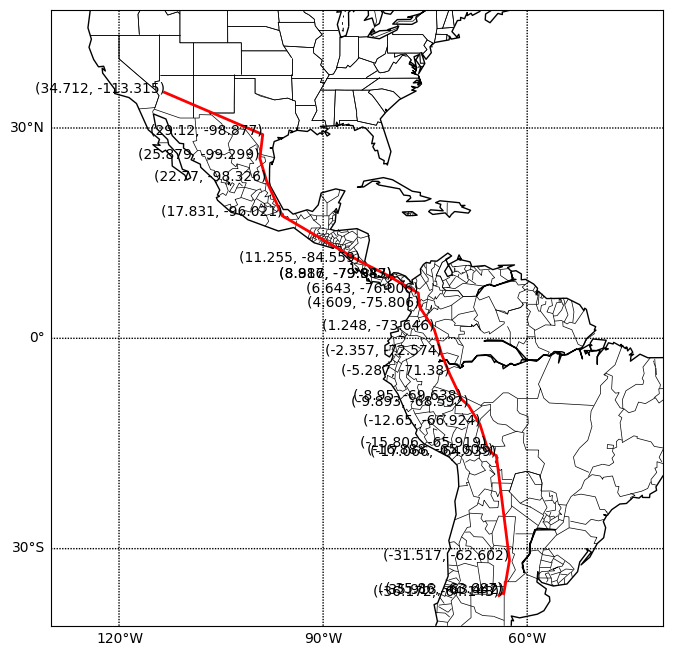

In [73]:
def plot_path_on_world_map(path, ax):
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert node coordinates to map coordinates
    path_map_coordinates = [m(node[1], node[0]) for node in path]

    # Plot the path
    ax.plot(*zip(*path_map_coordinates), color='r', linewidth=2)

    for node, coord in zip(path, path_map_coordinates):
        ax.text(coord[0], coord[1], str(node), fontsize=10, ha='right')

# Usage:
fig, ax = plt.subplots(figsize=(10, 8))
plot_path_on_world_map(path, ax)
plt.show()

In [40]:
# Create a copy of SWH_16
G = SWH_network.copy()

for u, v in G.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    G[u][v]['weight'] = weight

# Add nodes and edges to G
visited = {node: False for node in G.nodes}
start_node = (41.991, -121.63)
end_node = (-36.172, -64.143)
path, cost = minimumCostSimplePath(G, start_node, end_node, visited, [])

KeyboardInterrupt: 

### Bellman Ford

In [24]:
def bellman_ford(G, start_node, end_node):
    # Step 1: Prepare the distance and predecessor for each node
    distance = {node: float('infinity') for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    distance[start_node] = 0

    # Step 2: Relax edges
    for _ in range(len(G.nodes()) - 1):
        for (u, v, data) in G.edges(data=True):
            weight = 1/data['weight']
            if distance[u] + weight < distance[v]:
                distance[v] = distance[u] + weight
                predecessor[v] = u
            if distance[v] + weight < distance[u]:
                distance[u] = distance[v] + weight
                predecessor[u] = v

    # Step 3: Check for negative weight cycles
    for (u, v, data) in G.edges(data=True):
        weight = 1/data['weight']
        if distance[u] + weight < distance[v] or distance[v] + weight < distance[u]:
            raise ValueError("Graph contains a negative weight cycle")

    # If we've gotten this far, there's no negative weight cycle
    # Now we just need to return the shortest path
    path = []
    current_node = end_node
    while current_node is not None:
        path.append(current_node)
        current_node = predecessor[current_node]
    path = path[::-1]  # Reverse the list

    return path, distance[end_node]

In [105]:
import random

G = SWH_16.copy()
print(G)
nodes = list(G.nodes())

for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        if random.random() < 0.05:
            G.add_edge(nodes[i], nodes[j])

print(G)

for u, v in G.edges():
    # weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    G[u][v]['weight'] = haversine(u[0], u[1], v[0], v[1]) #weight

start_node = (34.712, -113.315)
end_node = (-36.172, -64.143)
path, cost = bellman_ford(G, start_node, end_node)

Graph with 33 nodes and 32 edges
Graph with 33 nodes and 59 edges


In [106]:
for (u, v, data) in G.edges(data=True):
    if u==start_node:
        print(u, v, data)
    elif v==start_node:
        print(u, v, data)

(22.77, -98.326) (34.712, -113.315) {'weight': 1970.1014681625381}
(8.887, -79.943) (34.712, -113.315) {'weight': 4446.078288639538}
(-17.066, -64.539) (34.712, -113.315) {'weight': 7724.383102453602}
(16.873, -93.871) (34.712, -113.315) {'weight': 2768.556291504218}


In [107]:
path, cost

([(34.712, -113.315),
  (8.887, -79.943),
  (25.879, -99.299),
  (-12.65, -66.924),
  (-15.806, -65.919),
  (-36.172, -64.143)],
 0.003928023836898401)

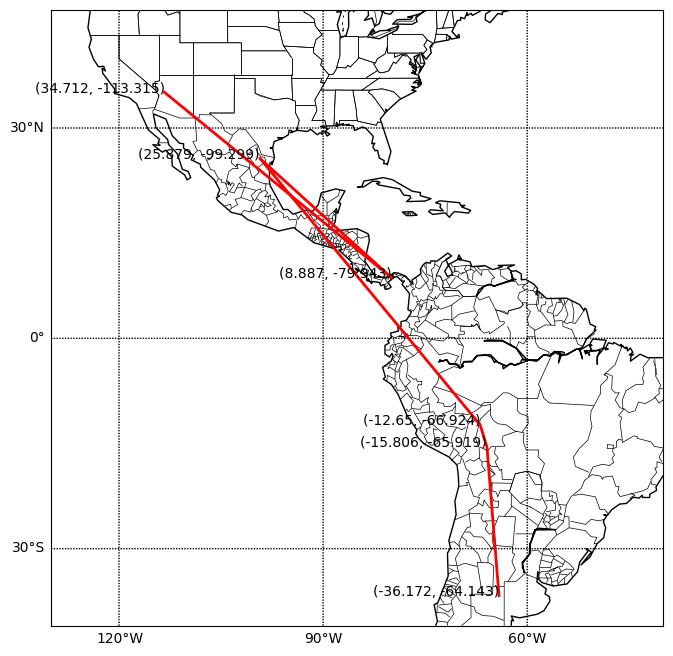

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_path_on_world_map(path, ax)
plt.show()

In [120]:
# Create a copy of SWH_16
G = SWH_network.copy()

for u, v in G.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    G[u][v]['weight'] = weight

# Add nodes and edges to G
visited = {node: False for node in G.nodes}
start_node = (41.991, -121.63)
end_node = (-36.172, -64.143)
path, cost = bellman_ford(G, start_node, end_node)

1.13966500279369 [(41.991, -121.63), (36.445, -120.221), (34.712, -113.315), (16.873, -93.871), (1.248, -74.331), (-6.011, -70.692), (-12.056, -66.116), (-31.451, -61.495), (-36.172, -64.143)]


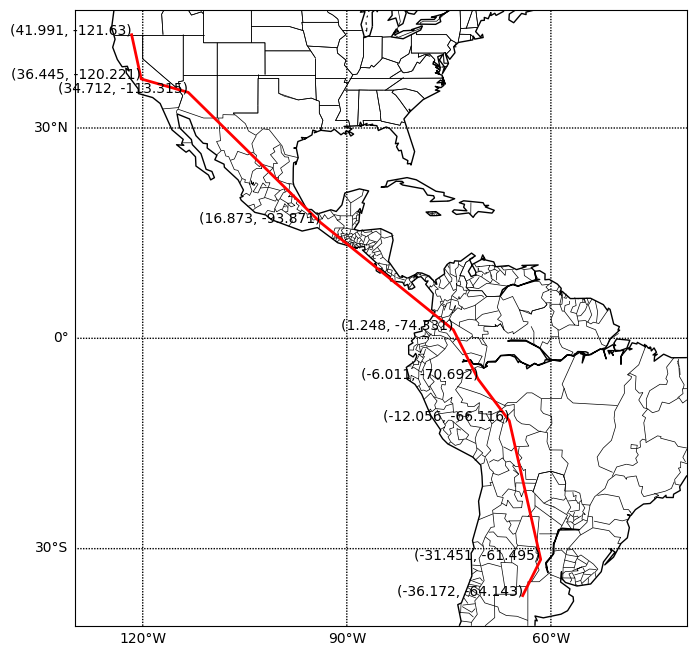

In [121]:
print(cost, path)
fig, ax = plt.subplots(figsize=(10, 8))
plot_path_on_world_map(path, ax)
plt.show()

### updated cost

In [103]:
def min_cost_path_(G, start_node, end_node):
    # Step 1: Prepare the distance and predecessor for each node
    distance = {node: float('infinity') for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    distance[start_node] = 0

    # Step 2: Relax edges
    for _ in range(len(G.nodes()) - 1):
        for (u, v, data) in G.edges(data=True):
            weight = 1/data['weight']
            if distance[u] + weight < distance[v]:
                distance[v] = distance[u] + weight
                predecessor[v] = u
            if distance[v] + weight < distance[u]:
                distance[u] = distance[v] + weight
                predecessor[u] = v

    # Step 3: Check for negative weight cycles
    for (u, v, data) in G.edges(data=True):
        weight = 1/data['weight']
        if distance[u] + weight < distance[v] or distance[v] + weight < distance[u]:
            raise ValueError("Graph contains a negative weight cycle")

    # If we've gotten this far, there's no negative weight cycle
    # Now we just need to return the shortest path
    path = []
    current_node = end_node
    while current_node is not None:
        path.append(current_node)
        current_node = predecessor[current_node]
    path = path[::-1]  # Reverse the list

    return path, distance[end_node]

In [108]:
def plot_path_on_world_map_(path, ax):
    m = Basemap(projection='mill', llcrnrlat=10, urcrnrlat=35, llcrnrlon=-125, urcrnrlon=-90, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert node coordinates to map coordinates
    path_map_coordinates = [m(node[1], node[0]) for node in path]

    # Plot the path
    ax.plot(*zip(*path_map_coordinates), color='r', linewidth=2)

    for node, coord in zip(path, path_map_coordinates):
        ax.text(coord[0], coord[1], str(node), fontsize=10, ha='right')

4.454774548216961 [(27.285, -109.232), (26.49, -105.646), (25.437, -103.972), (25.879, -99.299), (23.105, -98.297)]


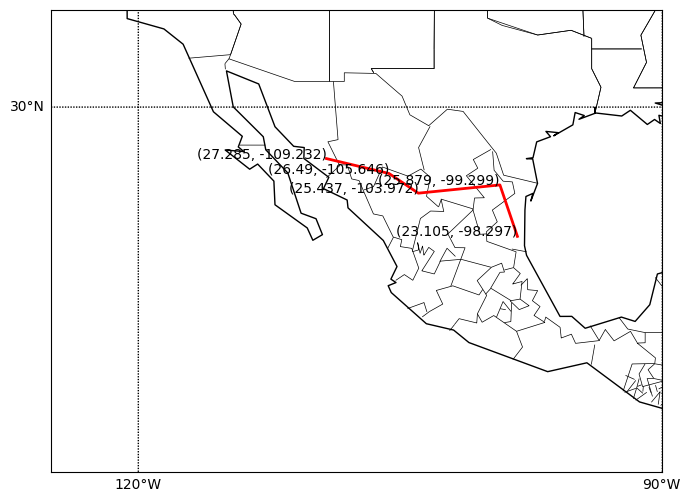

In [136]:
G = SWH_network.copy()
start_node = (27.285, -109.232)
end_node = (23.105, -98.297)
path, cost = min_cost_path_(G, start_node, end_node)
print(cost, path)
fig, ax = plt.subplots(figsize=(8, 6))
plot_path_on_world_map_(path, ax)
plt.show()

### define cost

In [139]:
max_distance = 0
min_weight = float('inf')

for (u, v, data) in G.edges(data=True):
    # u and v are the positions of the nodes
    lat1, lon1 = u
    lat2, lon2 = v
    
    # Calculate the haversine distance between the nodes u and v
    distance = haversine(lat1, lon1, lat2, lon2)
    max_distance = max(max_distance, distance)
    
    # Update the minimum weight
    min_weight = min(min_weight, data['weight'])

print("Maximum haversine distance:", max_distance)
print("Minimum weight:", min_weight)
print("Max Cost:", 1/min_weight)

Maximum haversine distance: 2768.556291504218
Minimum weight: 4.0903467607741886e-05
Max Cost: 24447.805002496363


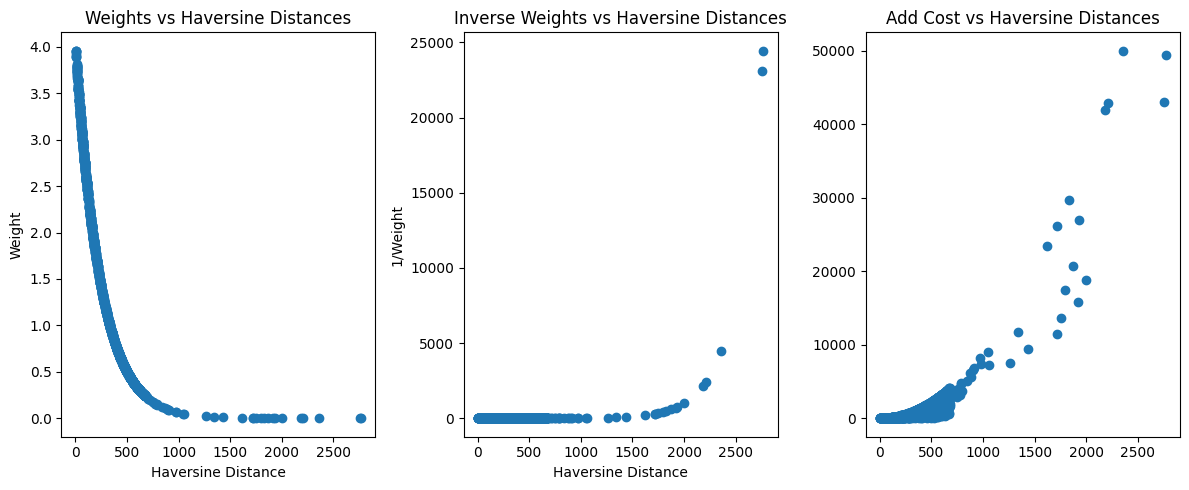

In [145]:
weights = []
inverse_weights = []
distances = []
add_cost = []

for (u, v, data) in G.edges(data=True):
    # u and v are the positions of the nodes
    lat1, lon1 = u
    lat2, lon2 = v
    
    # Calculate the haversine distance between the nodes u and v
    distance = haversine(lat1, lon1, lat2, lon2)
    distances.append(distance)

    add_cost.append(distance*abs(lat1-lat2))
    
    # Store the weight and 1/weight
    weight = data['weight']
    weights.append(weight)
    inverse_weights.append(1/(weight))

# Plot the weights and 1/weight values against the haversine distances
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(distances, weights)
plt.title('Weights vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Weight')

plt.subplot(1, 3, 2)
plt.scatter(distances, inverse_weights)
plt.title('Inverse Weights vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('1/Weight')

plt.subplot(1, 3, 3)
plt.scatter(distances, add_cost)
plt.title('Add Cost vs Haversine Distances')

plt.tight_layout()
plt.show()

In [147]:
len(distances)

1566

In [164]:
median_distance = np.median(distances)
print("Median of distances:", median_distance)

Median of distances: 390.7105977636296


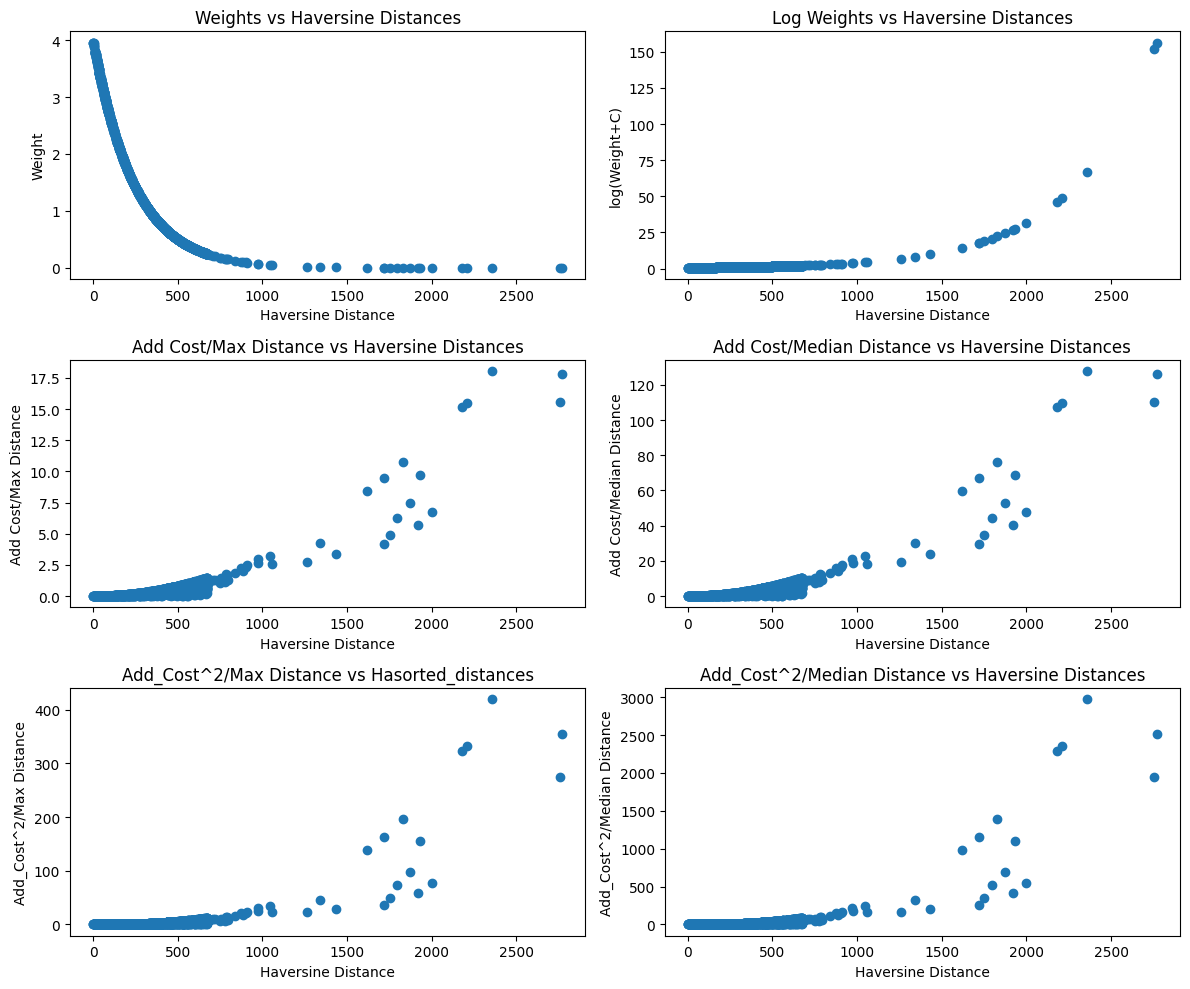

In [78]:
weights = []
log_weights = []
distances = []
add_cost = []
add_cost_2 = []

for (u, v, data) in G.edges(data=True):
    # u and v are the positions of the nodes
    lat1, lon1 = u
    lat2, lon2 = v
    
    # Calculate the haversine distance between the nodes u and v
    distance = haversine(lat1, lon1, lat2, lon2)
    distances.append(distance)

    add_cost.append(distance*abs(lat1-lat2))
    add_cost_2.append(distance*(abs(lat1-lat2)+1)**2)
    
    # Store the weight and 1/weight
    weight = data['weight']
    weights.append(weight)
    log_weights.append(1/np.sqrt(weight))

# Calculate max and median distance
max_distance = np.max(distances)
median_distance = np.median(distances)

# Plot the weights and 1/weight values against the haversine distances
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.scatter(distances, weights)
plt.title('Weights vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Weight')

plt.subplot(3, 2, 2)
plt.scatter(distances, log_weights)
plt.title('Log Weights vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('log(Weight+C)')

plt.subplot(3, 2, 3)
plt.scatter(distances, np.array(add_cost)/max_distance)
plt.title('Add Cost/Max Distance vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Add Cost/Max Distance')

plt.subplot(3, 2, 4)
plt.scatter(distances, np.array(add_cost)/median_distance)
plt.title('Add Cost/Median Distance vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Add Cost/Median Distance')

# Convert to numpy arrays
distances_np = np.array(distances)
add_cost_2_np = np.array(add_cost_2)

# Get the indices that would sort distances_np
sort_indices = np.argsort(distances_np)

# Use these indices to sort both arrays
sorted_distances = distances_np[sort_indices]
sorted_add_cost_2 = add_cost_2_np[sort_indices]
sorted_sq_cost = np.array(log_weights)[sort_indices]

plt.subplot(3, 2, 5)
plt.scatter(sorted_distances, sorted_add_cost_2/max_distance)
plt.title('Add_Cost^2/Max Distance vs Hasorted_distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Add_Cost^2/Max Distance')

plt.subplot(3, 2, 6)
plt.scatter(sorted_distances, sorted_add_cost_2/median_distance)
plt.title('Add_Cost^2/Median Distance vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Add_Cost^2/Median Distance')

plt.tight_layout()
plt.show()

In [208]:
y = np.array([3,1,4,2])
x = np.array([1,2,3,4])
sort_indices = np.argsort(y)
sort_indices , x[sort_indices]

(array([1, 3, 0, 2], dtype=int64), array([2, 4, 1, 3]))

In [370]:
# up_cost = np.sort(np.array(add_cost))
up_cost = sorted_add_cost_2/median_distance
g=0 ; f=10
sorted_distances[g:f],up_cost[g:f]

(array([ 2.61476244,  2.71495719,  2.7153264 ,  3.37291455,  4.5073197 ,
         6.03746479,  6.70423588,  6.94582446, 11.77329702, 12.04192247]),
 array([0.00686746, 0.00721533, 0.0072873 , 0.00912297, 0.0115824 ,
        0.01674561, 0.01753866, 0.01882346, 0.03184411, 0.03187737]))

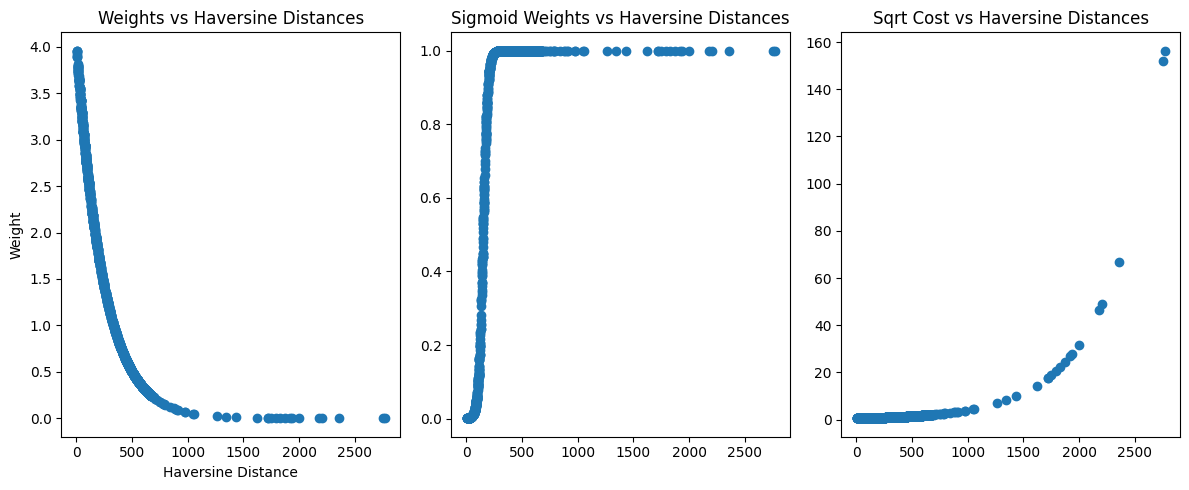

In [180]:
log_weights = []
distances = []
sqrt_weights = []
weights = []

for (u, v, data) in G.edges(data=True):
    # u and v are the positions of the nodes
    lat1, lon1 = u
    lat2, lon2 = v
    
    # Calculate the haversine distance between the nodes u and v
    distance = haversine(lat1, lon1, lat2, lon2)
    distances.append(distance)
    
    # Store the weight and 1/weight
    weight = data['weight']
    weights.append(weight)
    log_weights.append(1 / (1 + np.exp(-(distance - 150) / 20)))
    sqrt_weights.append(1 / np.sqrt(weight))

# Calculate max and median distance
max_distance = np.max(distances)
median_distance = np.median(distances)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(distances, weights)
plt.title('Weights vs Haversine Distances')
plt.xlabel('Haversine Distance')
plt.ylabel('Weight')

plt.subplot(1, 3, 2)
plt.scatter(distances, log_weights)
plt.title('Sigmoid Weights vs Haversine Distances')
# plt.xlabel('Haversine Distance')
# plt.ylabel('1/Weight')

plt.subplot(1, 3, 3)
plt.scatter(distances, sqrt_weights)
plt.title('Sqrt Cost vs Haversine Distances')

plt.tight_layout()
plt.show()

In [260]:
up_cost = sorted_add_cost_2/median_distance
g=1550 ; f=None
sorted_distances[g:f],up_cost[g:f], sorted_sq_cost[g:f]

(array([1433.28795222, 1618.72344261, 1717.80501129, 1719.23019737,
        1751.24598519, 1794.45522843, 1828.56712863, 1870.65442569,
        1919.45584943, 1932.86470252, 1999.37662644, 2181.89010085,
        2208.06405849, 2357.92825282, 2755.07753028, 2768.5562915 ]),
 array([ 210.55142789,  989.07824601,  261.48857347, 1156.37435292,
         343.87532512,  527.10804618, 1393.27005935,  695.55053268,
         421.16386638, 1104.79062841,  552.6341206 , 2284.08253902,
        2350.73620724, 2973.20481307, 1948.95558215, 2514.86026541]),
 array([  9.78847095,  14.38261405,  17.66585582,  17.71818062,
         18.93534495,  20.71168219,  22.23097871,  24.25993235,
         26.84551051,  27.60300352,  31.68837272,  46.27958472,
         48.86283091,  66.68729646, 152.04504047, 156.35793873]))

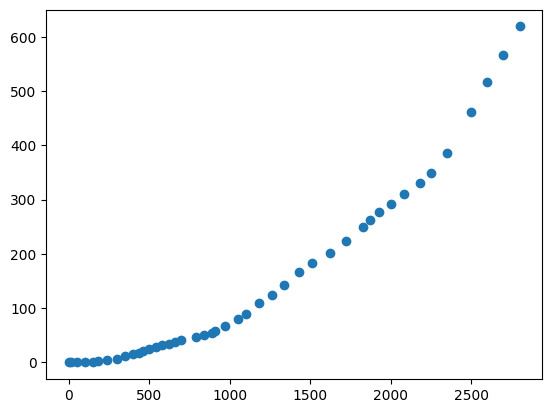

In [28]:
hd = np.array([0.0002,15,50,100,150,180,240,300,350,400,435,460,500,540,580,625,660,700,790,840,890,910,970,1050,1100,1180,1260,1340,1430,1510,1620,1720,1830,1870,1930,2000,2080,2180,2250,2350,2500,2600,2700,2800])
y = np.array([0.0001,0.105,0.55,1.2,1.78,2.25,4.5,7.1,11.8,15.5,18.1,20.9,24,27.8,31.6,33.8,37.2,40.5,47.6,51.3,55,57.1,68,80,90,109,124,143,167,184,202,223,249,263,277,292,311,330.5,349.7,386.3,461,516,565.8,619])
plt.scatter(hd, y)

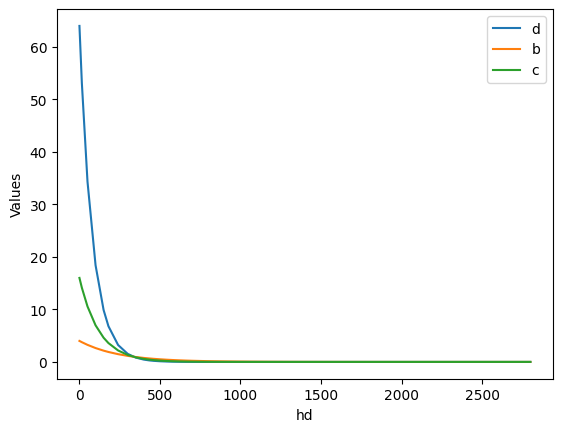

In [29]:
def p(d, k):
    return np.exp(-k * d)

def weight_of_edge(n, k, d):
    return n * p(d, k)

# Convert your data to numpy arrays
b = np.array(weight_of_edge(n_SWH, k_SWH, hd))
a = 1 / b
c = b ** 2
d = b ** 3
e = a ** 2

# Plotting a, b, and c with respect to hd
plt.plot(hd, d, label='d')
plt.plot(hd, b, label='b')
plt.plot(hd, c, label='c')
# plt.plot(hd, e, label='e')

# Adding labels and legend
plt.xlabel('hd')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()

c:\Users\Yashraj Deshmukh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.2865e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


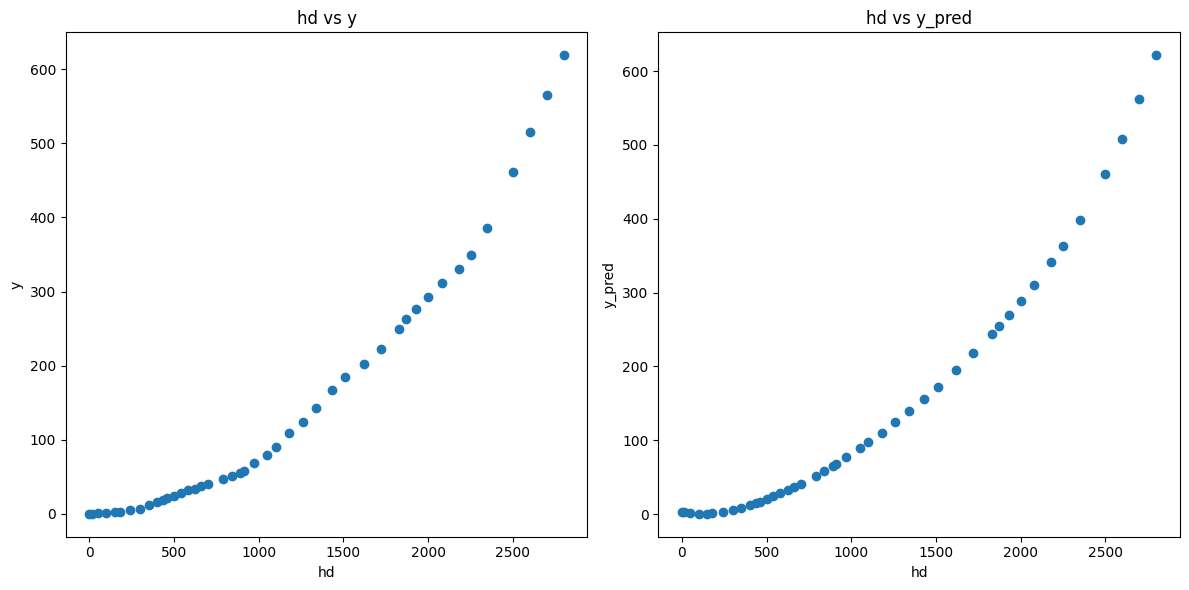

In [30]:
from sklearn.linear_model import LinearRegression, Ridge

# Stack the arrays in sequence horizontally (column wise)
X = np.column_stack((a,hd,e,hd**2,b))

# Fit the model
model = Ridge(alpha=0.0)
model.fit(X, y)

# Predict y
y_pred = model.predict(X)

# Plot hd vs y and hd vs y_pred
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(hd, y)
plt.title('hd vs y')
plt.xlabel('hd')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(hd, y_pred)
plt.title('hd vs y_pred')
plt.xlabel('hd')
plt.ylabel('y_pred')

plt.tight_layout()
plt.show()

c:\Users\Yashraj Deshmukh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.2865e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Coefficients:  [ 5.28015584e-03  5.32880556e-02 -5.35349889e-08  4.95687954e-05
  1.23519628e+00]
Bias term:  -4.80810452156922


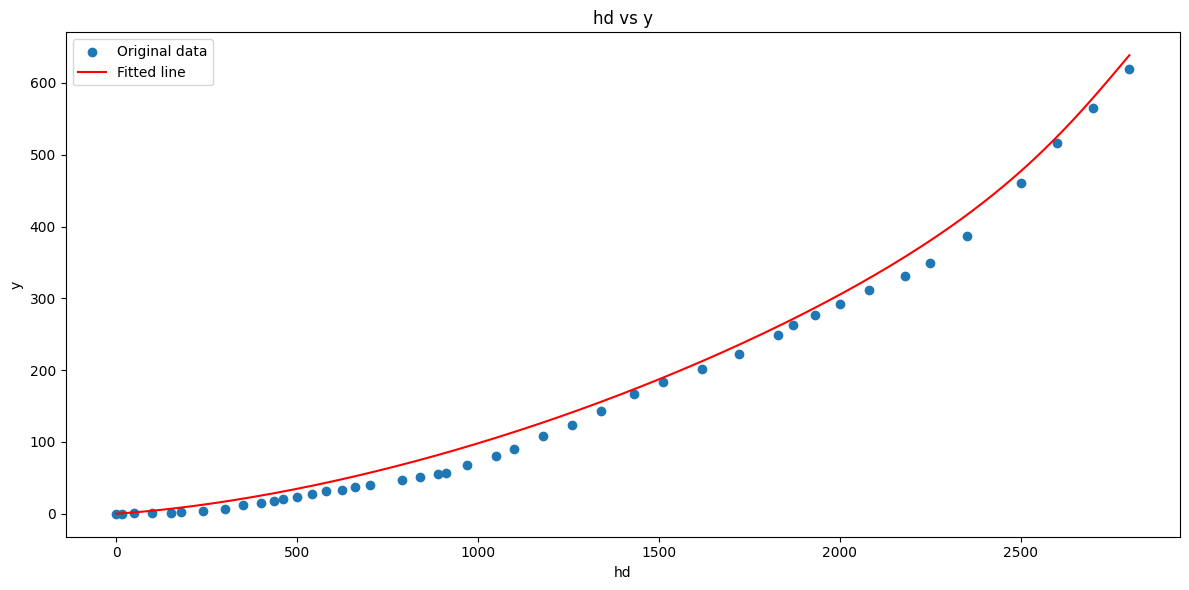

In [80]:
# Fit the model
model = Ridge(alpha=0.0)
model.fit(X, y)

# Predict y
y_pred = model.predict(X)

# Create a range of x values
x_values = np.linspace(min(hd), max(hd), num=200)

# Create the corresponding y values
b_values = weight_of_edge(n_SWH, k_SWH, x_values)
a_values = 1 / b_values
e_values = a_values ** 2

model.intercept_ += 17
model.coef_[-1] /= 5
# model.coef_[-3] *= 5

X_values = np.column_stack((a_values, x_values, e_values, x_values**2, b_values))
y_values = model.predict(X_values)

# Print the coefficients
print('Coefficients: ', model.coef_)
# Print the bias term
print('Bias term: ', model.intercept_)

# Plot hd vs y and the function line
plt.figure(figsize=(12, 6))

plt.scatter(hd, y, label='Original data')
plt.plot(x_values, y_values, color='red', label='Fitted line')
# plt.scatter(hd, y_pred, color='green', label='Predicted data')
 
plt.title('hd vs y')
plt.xlabel('hd')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
x_values[:10],y_values[:10]

(array([2.00000000e-04, 1.40705508e+01, 2.81409015e+01, 4.22112523e+01,
        5.62816030e+01, 7.03519538e+01, 8.44223045e+01, 9.84926553e+01,
        1.12563006e+02, 1.26633357e+02]),
 array([0.1340072 , 0.61341589, 1.1283542 , 1.67792059, 2.26126469,
        2.87758443, 3.52612325, 4.20616755, 4.91704426, 5.65811853]))

In [34]:
hd[:10],y[:10]

(array([2.0e-04, 1.5e+01, 5.0e+01, 1.0e+02, 1.5e+02, 1.8e+02, 2.4e+02,
        3.0e+02, 3.5e+02, 4.0e+02]),
 array([1.00e-04, 1.05e-01, 5.50e-01, 1.20e+00, 1.78e+00, 2.25e+00,
        4.50e+00, 7.10e+00, 1.18e+01, 1.55e+01]))

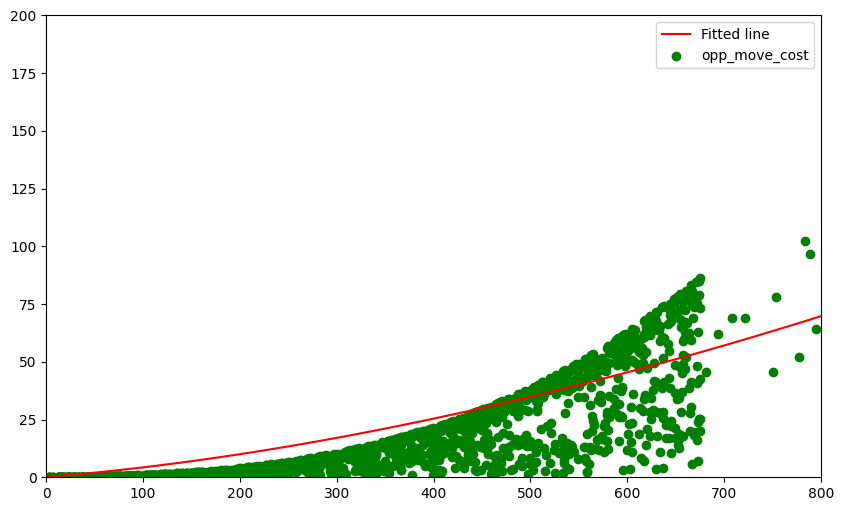

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, color='red', label='Fitted line')
plt.scatter(sorted_distances, sorted_add_cost_2/median_distance, color='green', label='opp_move_cost')
plt.legend()
plt.xlim(0,800)
plt.ylim(0,200)
plt.show()

### Final Cost Function

In [85]:
print("n_SWH:", n_SWH)
print("k_SWH:", k_SWH)
print("median_distance:", median_distance)

n_SWH: 4
k_SWH: 0.004150390625
median_distance: 390.7105977636296


In [90]:
def cost_of_edge(hd,b):
    # b = weight_of_edge(n_SWH, k_SWH, hd)
    a = 1 / b
    e = a ** 2
    return model.predict(np.column_stack((a,hd,e,hd**2,b)))

In [ ]:
# lat1, lon1 = u
# lat2, lon2 = v
# d = haversine(lat1, lon1, lat2, lon2)
# add_cost_2.append(distance*(abs(lat1-lat2)+1)**2)

# # Step 3: Check for negative weight cycles
# for (u, v, data) in G.edges(data=True):
#     lat1, lon1 = u
#     lat2, lon2 = v
#     d = haversine(lat1, lon1, lat2, lon2)
#     b = data['weight']
#     weight_u_to_v = cost_of_edge(d,b) + cost_of_opposite_movement(lat1, lat2, d)
#     weight_v_to_u = cost_of_edge(d,b) + cost_of_opposite_movement(lat2, lat1, d)
#     if distance[u] + weight_u_to_v < distance[v] or distance[v] + weight_v_to_u < distance[u]:
#         raise ValueError("Graph contains a negative weight cycle")

In [86]:
def cost_of_opposite_movement(lat1,lat2,d):
    if lat1>lat2:
        return 0
    else:
        return d*(abs(lat1-lat2)+1)**2

In [76]:
for h in x_values[:10]:
    print(h, cost_of_edge(h), end=", ")

0.0002 [0.1340072], 14.070550753768844 [0.61341589], 28.140901507537688 [1.1283542], 42.211252261306534 [1.67792059], 56.281603015075376 [2.26126469], 70.35195376884423 [2.87758443], 84.42230452261308 [3.52612325], 98.49265527638191 [4.20616755], 112.56300603015076 [4.91704426], 126.63335678391961 [5.65811853], 

In [106]:
def min_cost_path__(G, start_node, end_node):
    # Step 1: Prepare the distance and predecessor for each node
    distance = {node: float('infinity') for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    distance[start_node] = 0

    # Step 2: Relax edges
    for _ in range(len(G.nodes()) - 1):
        for (u, v, data) in G.edges(data=True):
            lat1, lon1 = u
            lat2, lon2 = v
            d = haversine(lat1, lon1, lat2, lon2)
            b = data['weight']
            weight_u_to_v = cost_of_edge(d,b) + cost_of_opposite_movement(lat1, lat2, d)
            weight_v_to_u = cost_of_edge(d,b) + cost_of_opposite_movement(lat2, lat1, d)
            
            if distance[u] + weight_u_to_v < distance[v]:
                distance[v] = distance[u] + weight_u_to_v
                predecessor[v] = u
            if distance[v] + weight_v_to_u < distance[u]:
                distance[u] = distance[v] + weight_v_to_u
                predecessor[u] = v

    # Now we just need to return the shortest path
    path = []
    current_node = end_node
    while current_node is not None:
        path.append(current_node)
        current_node = predecessor[current_node]
    path = path[::-1]  # Reverse the list

    return path, distance[end_node]

[80.88467037] [(27.285, -109.232), (27.251, -109.054), (26.49, -105.646), (25.437, -103.972), (23.105, -98.297)]


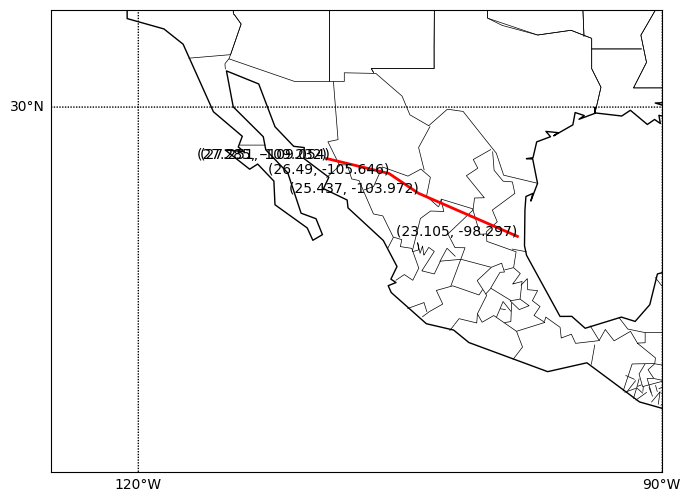

In [97]:
G = SWH_network.copy()
start_node = (27.285, -109.232)
end_node = (23.105, -98.297)
path, cost = min_cost_path__(G, start_node, end_node)
print(cost, path)
fig, ax = plt.subplots(figsize=(8, 6))
plot_path_on_world_map_(path, ax)
plt.show()

In [101]:
def plot_path_on_world_map(path, ax):
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert node coordinates to map coordinates
    path_map_coordinates = [m(node[1], node[0]) for node in path]

    # Plot the path
    ax.plot(*zip(*path_map_coordinates), color='r', linewidth=2)

    # for node, coord in zip(path, path_map_coordinates):
    #     ax.text(coord[0], coord[1], str(node), fontsize=10, ha='right')

[590.64076673] [(34.712, -113.315), (32.64, -114.03), (27.285, -109.232), (27.251, -109.054), (26.49, -105.646), (25.437, -103.972), (21.95, -100.339), (21.875, -99.654), (19.938, -96.737), (18.21, -95.961), (17.538, -95.427), (16.873, -93.871), (15.49, -93.198), (15.395, -92.714), (14.725, -91.832), (14.333, -91.134), (14.004, -90.551), (13.9, -89.592), (13.895, -88.938), (13.601, -87.456), (13.432, -87.335), (12.475, -86.21), (11.255, -84.559), (8.977, -80.23), (8.916, -79.887), (7.707, -77.466), (7.101, -76.928), (6.625, -76.498), (5.753, -75.572), (4.609, -75.806), (3.43, -75.102), (1.829, -74.152), (1.248, -73.646), (-0.904, -73.269), (-2.784, -72.87), (-4.982, -71.921), (-5.287, -71.38), (-6.011, -70.692), (-7.752, -70.423), (-8.95, -69.638), (-9.589, -68.917), (-9.893, -68.592), (-11.717, -66.795), (-12.902, -66.534), (-15.806, -65.919), (-16.888, -65.005), (-17.066, -64.539), (-17.998, -63.39), (-18.474, -63.024), (-21.495, -62.512), (-22.796, -61.923), (-24.79, -62.407), (-26.

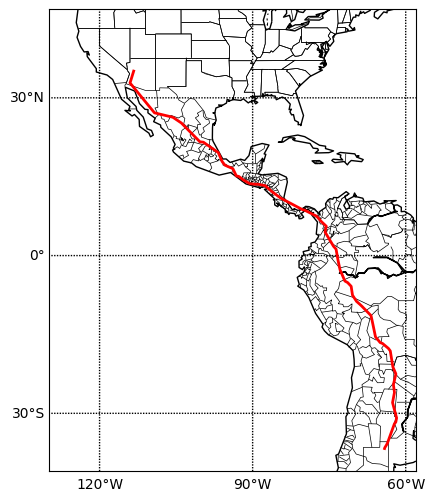

In [102]:
start_node = (34.712, -113.315)
end_node = (-36.172, -64.143)
path, cost = min_cost_path__(G, start_node, end_node)
print(cost, path)
fig, ax = plt.subplots(figsize=(8, 6))
plot_path_on_world_map(path, ax)
plt.show()

In [131]:
def min_cost_path(G, start_node, end_node):
    # Step 1: Prepare the distance, path length and predecessor for each node
    distance = {node: float('infinity') for node in G.nodes()}
    path_length = {node: 0 for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    distance[start_node] = 0

    # Step 2: Relax edges
    for _ in range(len(G.nodes()) - 1):
        for (u, v, data) in G.edges(data=True):
            lat1, lon1 = u
            lat2, lon2 = v
            d = haversine(lat1, lon1, lat2, lon2)
            b = data['weight']
            weight_u_to_v = cost_of_edge(d,b) + cost_of_opposite_movement(lat1, lat2, d)
            weight_v_to_u = cost_of_edge(d,b) + cost_of_opposite_movement(lat2, lat1, d)
            
            # t=0
            if v == end_node:
                # t=1
                weight_u_to_v += path_length[u] * math.log(path_length[u]+1)

            if u==end_node:
                weight_v_to_u += path_length[v] * math.log(path_length[v]+1)
                # t=1

            if distance[u] + weight_u_to_v < distance[v]:
                # if t:
                    # print("should")
                distance[v] = distance[u] + weight_u_to_v
                path_length[v] = path_length[u] + 1
                predecessor[v] = u
                
            if distance[v] + weight_v_to_u < distance[u]:
                # if t:
                    # print("could")
                distance[u] = distance[v] + weight_v_to_u
                path_length[u] = path_length[v] + 1
                predecessor[u] = v

    # Now we just need to return the shortest path
    path = []
    current_node = end_node
    while current_node is not None:
        path.append(current_node)
        current_node = predecessor[current_node]
    path = path[::-1]  # Reverse the list

    return path, distance[end_node], path_length[end_node]

could
could
could
4 [85.04355346] [(27.285, -109.232), (27.251, -109.054), (26.49, -105.646), (25.437, -103.972), (23.105, -98.297)]


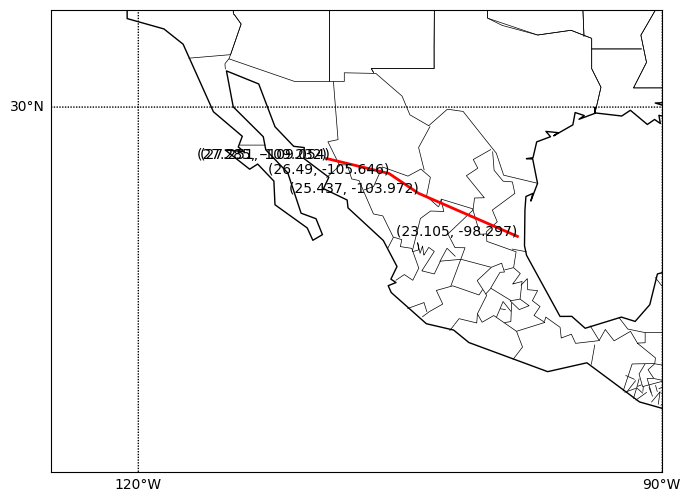

In [129]:
start_node = (27.285, -109.232)
end_node = (23.105, -98.297)
path, cost, hops = min_cost_path(G, start_node, end_node)
print(hops, cost, path)
fig, ax = plt.subplots(figsize=(8, 6))
plot_path_on_world_map_(path, ax)
plt.show()

46 [787.89794147] [(34.712, -113.315), (32.64, -114.03), (27.285, -109.232), (27.251, -109.054), (26.49, -105.646), (25.437, -103.972), (21.95, -100.339), (21.875, -99.654), (19.938, -96.737), (18.21, -95.961), (17.538, -95.427), (16.873, -93.871), (15.49, -93.198), (15.395, -92.714), (14.725, -91.832), (14.333, -91.134), (14.004, -90.551), (13.9, -89.592), (13.895, -88.938), (13.601, -87.456), (13.432, -87.335), (12.475, -86.21), (11.255, -84.559), (8.977, -80.23), (8.916, -79.887), (7.707, -77.466), (7.101, -76.928), (6.625, -76.498), (5.753, -75.572), (4.609, -75.806), (3.43, -75.102), (1.829, -74.152), (1.248, -73.646), (-0.904, -73.269), (-2.784, -72.87), (-4.982, -71.921), (-5.287, -71.38), (-6.011, -70.692), (-7.752, -70.423), (-8.95, -69.638), (-9.589, -68.917), (-9.893, -68.592), (-11.717, -66.795), (-12.902, -66.534), (-15.806, -65.919), (-16.888, -65.005), (-17.066, -64.539), (-17.998, -63.39), (-18.474, -63.024), (-21.495, -62.512), (-22.796, -61.923), (-24.79, -62.407), (-

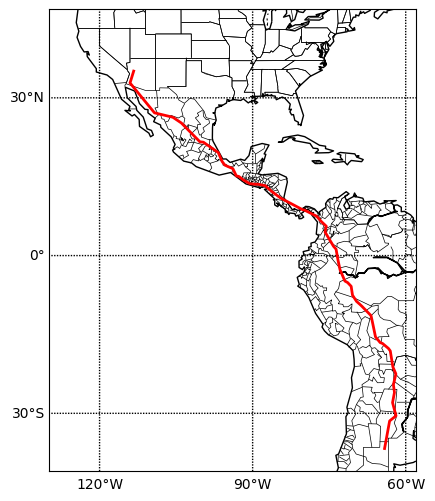

In [132]:
start_node = (34.712, -113.315)
end_node = (-36.172, -64.143)
path, cost, hops = min_cost_path(G, start_node, end_node)
print(hops, cost, path)
fig, ax = plt.subplots(figsize=(8, 6))
plot_path_on_world_map(path, ax)
plt.show()

# Trail Completion

Vulnerable nodes = 6: [(15.395, -92.714), (14.333, -91.134), (15.49, -93.198), (14.004, -90.551), (14.725, -91.832), (14.384, -90.45)]


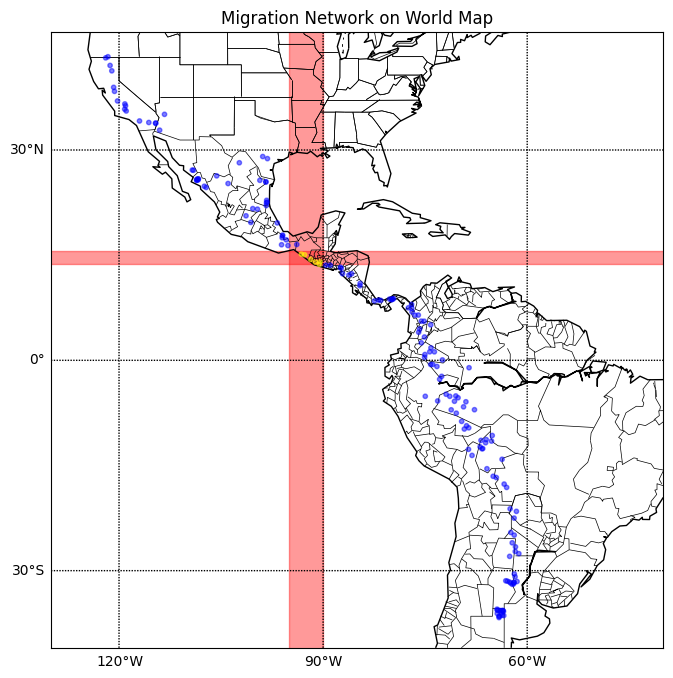

In [134]:
plot_migration_network_vul(SWH_network, [14,16,-90,-95], True)

In [141]:
vulnerable_nodes = [(15.395, -92.714), (14.333, -91.134), (15.49, -93.198), (14.004, -90.551), (14.725, -91.832), (14.384, -90.45)]
vulnerable = [14,16,-90,-95]

In [140]:
delete_vulnerable_nodes(SWH_16, vulnerable) , delete_vulnerable_nodes(SWH_17, vulnerable) , delete_vulnerable_nodes(SWH_18, vulnerable) , delete_vulnerable_nodes(SWH_25, vulnerable)

(1, 3, 3, 3)

In [142]:
import copy

def remove_vulnerable_nodes(G, vulnerable_nodes):
    # Create a copy of the graph
    G_copy = copy.deepcopy(G)
    
    # Remove the vulnerable nodes from the copy
    for node in vulnerable_nodes:
        if node in G_copy:
            G_copy.remove_node(node)
    
    return G_copy

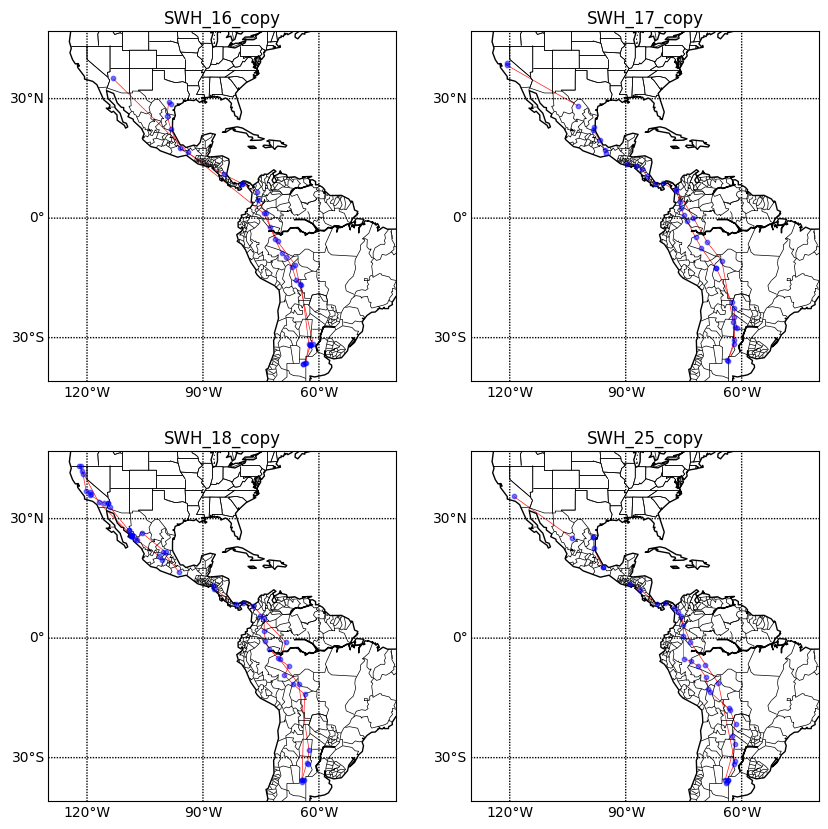

In [148]:
# Create copies of the graphs and remove the vulnerable nodes
SWH_16_copy = remove_vulnerable_nodes(SWH_16, vulnerable_nodes)
SWH_17_copy = remove_vulnerable_nodes(SWH_17, vulnerable_nodes)
SWH_18_copy = remove_vulnerable_nodes(SWH_18, vulnerable_nodes)
SWH_25_copy = remove_vulnerable_nodes(SWH_25, vulnerable_nodes)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Draw the graphs on the subplots
plot_trail_on_world_map(SWH_16_copy, ax=axs[0, 0])
axs[0, 0].set_title('SWH_16_copy')
plot_trail_on_world_map(SWH_17_copy, ax=axs[0, 1])
axs[0, 1].set_title('SWH_17_copy')
plot_trail_on_world_map(SWH_18_copy, ax=axs[1, 0])
axs[1, 0].set_title('SWH_18_copy')
plot_trail_on_world_map(SWH_25_copy, ax=axs[1, 1])
axs[1, 1].set_title('SWH_25_copy')

# Show the plot
plt.show()

In [169]:
def plot_vul_trail_on_world_map(migration_network, ax, vulnerable_nodes):
    m = Basemap(projection='mill', llcrnrlat=0, urcrnrlat=30, llcrnrlon=-120, urcrnrlon=-70, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color='blue', alpha=0.5, ax=ax)

    # Draw the edges
    for (u, v) in migration_network.edges():
        if u in vulnerable_nodes or v in vulnerable_nodes:
            edge_color = 'red'
        else:
            edge_color = 'yellow'
        nx.draw_networkx_edges(migration_network, pos, edgelist=[(u, v)], width=0.5, edge_color=edge_color, alpha=0.9, ax=ax)

    # Draw the labels of the neighbors of the vulnerable nodes
    neighbors_labels = {n: n for v in vulnerable_nodes if v in migration_network for n in migration_network.neighbors(v)}
    nx.draw_networkx_labels(migration_network, pos, labels=neighbors_labels, font_size=10, ax=ax, horizontalalignment='right')

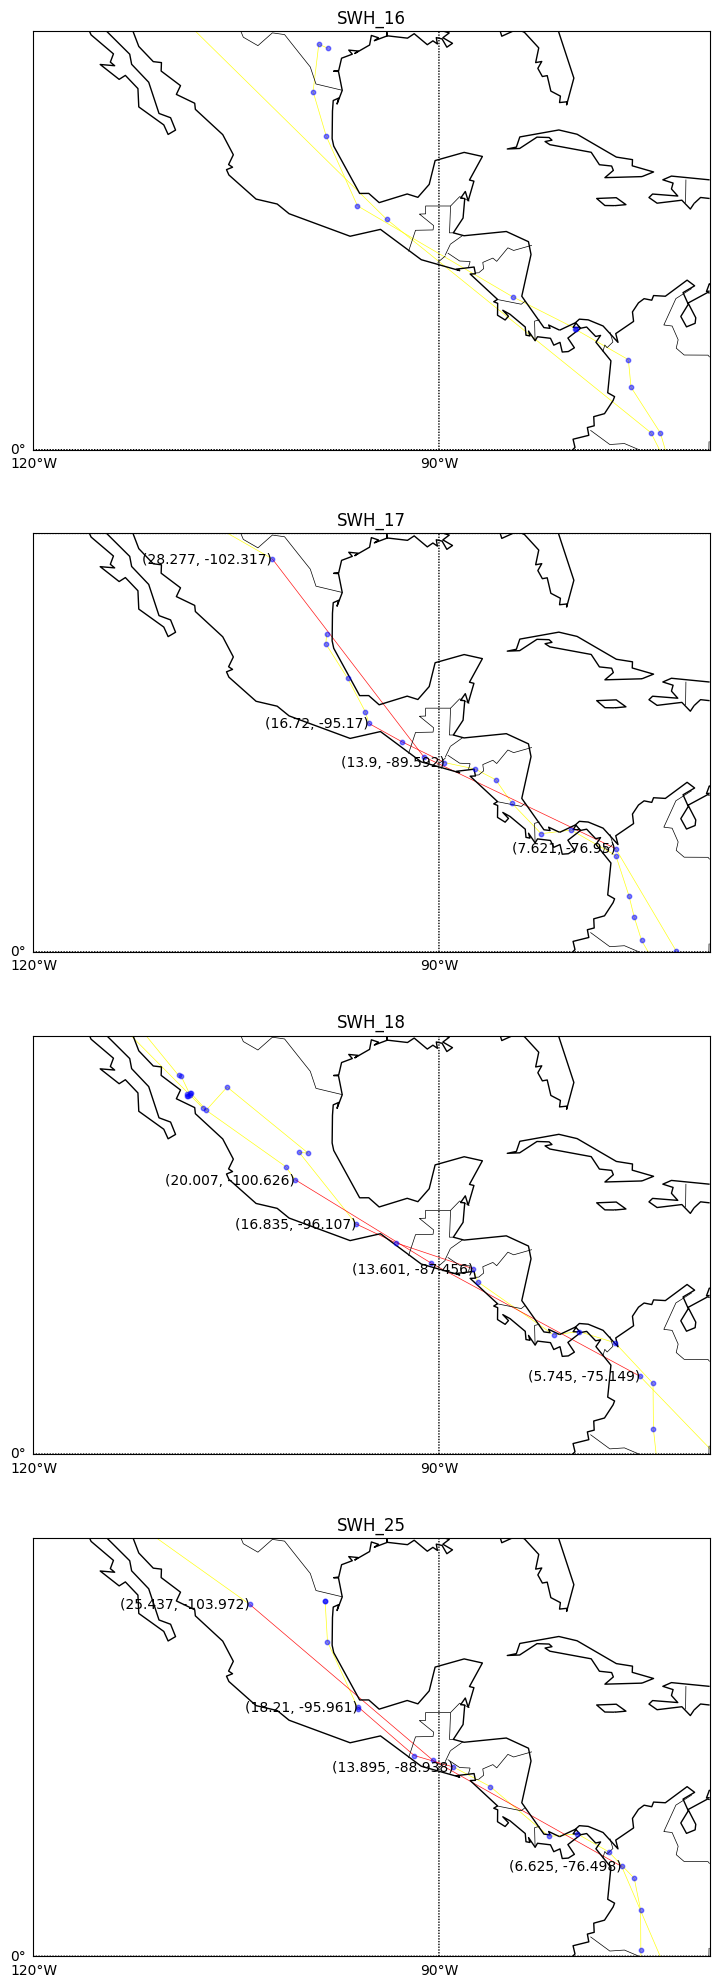

In [170]:
# Create a 4x1 subplot
fig, axs = plt.subplots(4, 1, figsize=(10, 25))

# Draw the graphs on the subplots
plot_vul_trail_on_world_map(SWH_16, ax=axs[0], vulnerable_nodes=vulnerable_nodes)
axs[0].set_title('SWH_16')
plot_vul_trail_on_world_map(SWH_17, ax=axs[1], vulnerable_nodes=vulnerable_nodes)
axs[1].set_title('SWH_17')
plot_vul_trail_on_world_map(SWH_18, ax=axs[2], vulnerable_nodes=vulnerable_nodes)
axs[2].set_title('SWH_18')
plot_vul_trail_on_world_map(SWH_25, ax=axs[3], vulnerable_nodes=vulnerable_nodes)
axs[3].set_title('SWH_25')

# Show the plot
# plt.tight_layout()
plt.show()

In [172]:
def alternate_trail_reconstruct(vulnerable_nodes, start_node, end_node):

    G = remove_vulnerable_nodes(SWH_network, vulnerable_nodes)

    assert start_node in G.nodes()
    assert end_node in G.nodes()
    
    # Step 1: Prepare the distance, path length and predecessor for each node
    distance = {node: float('infinity') for node in G.nodes()}
    path_length = {node: 0 for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    distance[start_node] = 0

    # Step 2: Relax edges
    for _ in range(len(G.nodes()) - 1):
        for (u, v, data) in G.edges(data=True):
            lat1, lon1 = u
            lat2, lon2 = v
            d = haversine(lat1, lon1, lat2, lon2)
            b = data['weight']
            weight_u_to_v = cost_of_edge(d,b) + cost_of_opposite_movement(lat1, lat2, d)
            weight_v_to_u = cost_of_edge(d,b) + cost_of_opposite_movement(lat2, lat1, d)
            
            if v == end_node:
                weight_u_to_v += path_length[u] * math.log(path_length[u]+1)

            if u==end_node:
                weight_v_to_u += path_length[v] * math.log(path_length[v]+1)

            if distance[u] + weight_u_to_v < distance[v]:
                distance[v] = distance[u] + weight_u_to_v
                path_length[v] = path_length[u] + 1
                predecessor[v] = u
                
            if distance[v] + weight_v_to_u < distance[u]:
                distance[u] = distance[v] + weight_v_to_u
                path_length[u] = path_length[v] + 1
                predecessor[u] = v

    # Now we just need to return the shortest path
    path = []
    current_node = end_node
    while current_node is not None:
        path.append(current_node)
        current_node = predecessor[current_node]
    path = path[::-1]  # Reverse the list

    return path, distance[end_node], path_length[end_node]

In [173]:
#SWH_17
path_up, cost_up, hops_up = alternate_trail_reconstruct(vulnerable_nodes, (28.277,-102.317), (7.621, -76.95))
path_down, cost_down, hops_down = alternate_trail_reconstruct(vulnerable_nodes, (16.72, -95.17), (13.9, -89.592))

In [175]:
path_up, cost_up, hops_up

([(28.277, -102.317),
  (25.879, -99.299),
  (23.105, -98.297),
  (22.77, -98.326),
  (22.38, -98.355),
  (19.938, -96.737),
  (18.21, -95.961),
  (17.538, -95.427),
  (16.873, -93.871),
  (13.9, -89.592),
  (13.895, -88.938),
  (13.601, -87.456),
  (13.432, -87.335),
  (12.475, -86.21),
  (11.255, -84.559),
  (8.977, -80.23),
  (7.621, -76.95)],
 array([263.32839739]),
 15)

In [176]:
path_down, cost_down, hops_down

([(16.72, -95.17), (13.9, -89.592)], array([54.1098392]), 1)

In [187]:
SWH_17_copy = remove_vulnerable_nodes(SWH_17, vulnerable_nodes)
SWH_network_copy = remove_vulnerable_nodes(SWH_network, vulnerable_nodes)

In [204]:
def plot_reconstruction(paths_up, paths_down, remainder_trail, remainder_network):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert trail node coordinates to map coordinates
    pos_trail = {node: m(node[1], node[0]) for node in remainder_network.nodes()}

    # Draw the nodes in the paths with a different color
    nx.draw_networkx_nodes(paths_up, pos_trail, node_size=10, node_color='violet', alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(paths_down, pos_trail, node_size=10, node_color='violet', alpha=0.5, ax=ax)
 
    # Draw the remainder trail
    nx.draw_networkx_nodes(remainder_trail, pos_trail, node_size=10, node_color='blue', alpha=0.5, ax=ax)
    nx.draw_networkx_edges(remainder_trail, pos_trail, width=0.5, edge_color='orange', alpha=1, ax=ax)

    # Create graph objects from paths
    graph_up = nx.Graph()
    graph_down = nx.Graph()
    for i in range(len(paths_up)-1):
        graph_up.add_edge(paths_up[i], paths_up[i+1])
    for i in range(len(paths_down)-1):
        graph_down.add_edge(paths_down[i], paths_down[i+1])

    # Draw the edges in the paths with a different color
    nx.draw_networkx_edges(graph_up, pos_trail, width=2, edge_color='darkgreen', alpha=0.5, ax=ax)
    nx.draw_networkx_edges(graph_down, pos_trail, width=2, edge_color='red', alpha=0.5, ax=ax)

    plt.show()

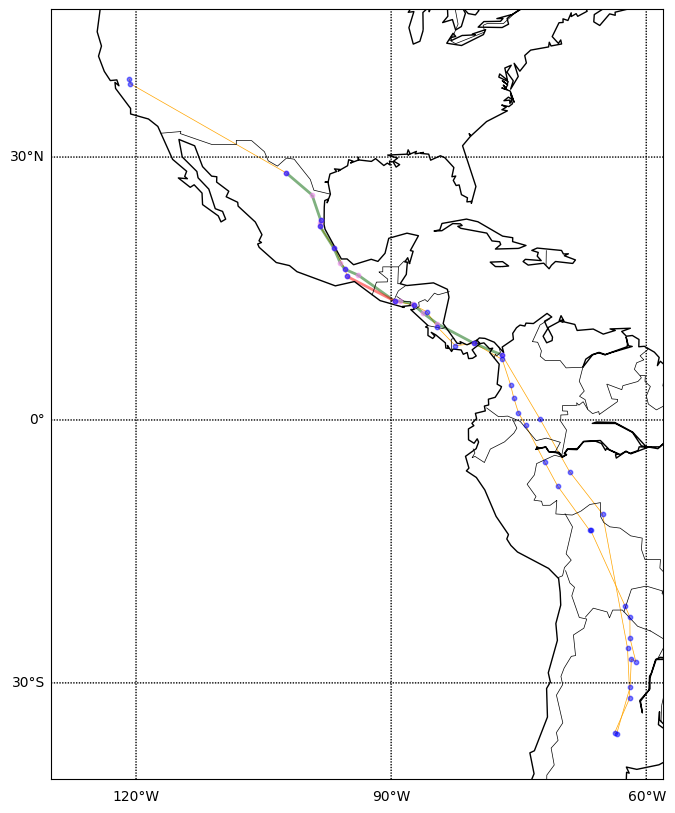

In [205]:
plot_reconstruction(path_up, path_down, SWH_17_copy, SWH_network_copy)